/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_70155/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_70155/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_70155/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


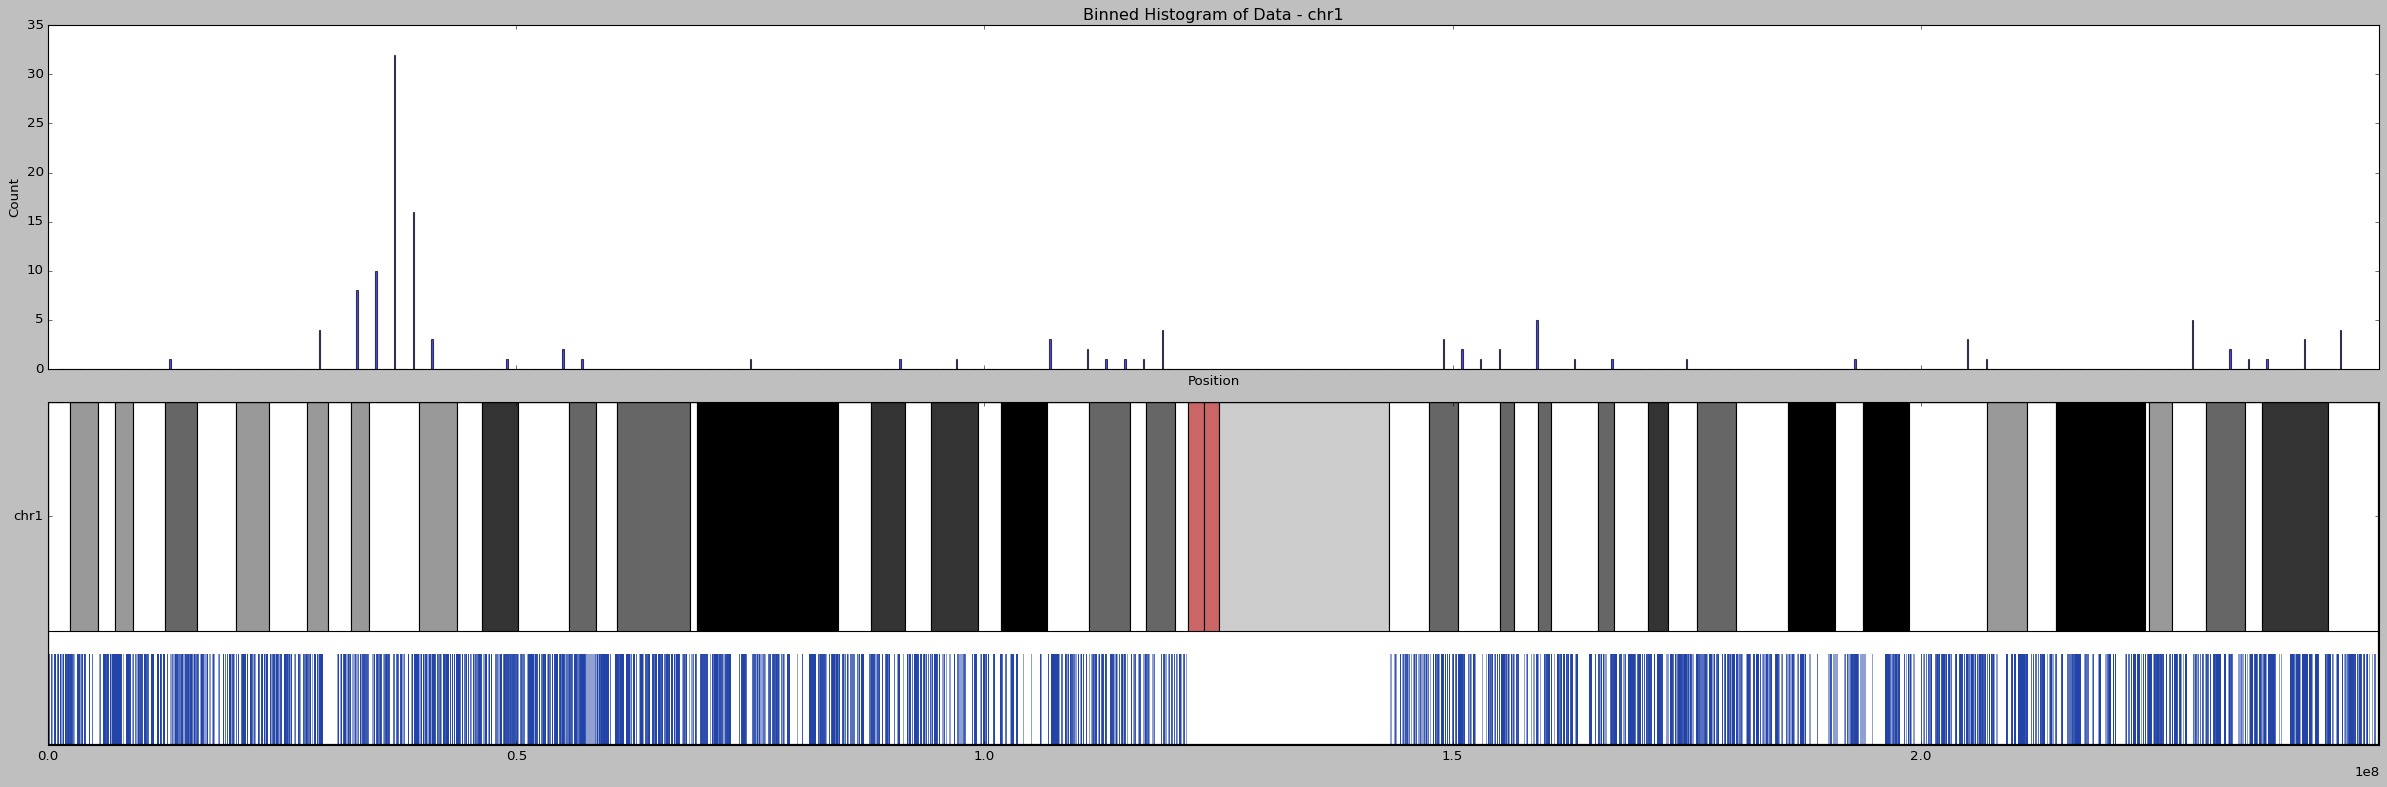

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import BrokenBarHCollection
from matplotlib.patches import Rectangle

plt.style.use('classic')

# Function to bin the data
def bin_data(data, bin_size):
    binned_data = []
    for chromosome in data['Chromosome'].unique():
        chrom_data = data[data['Chromosome'] == chromosome]
        bins = np.arange(chrom_data['Position'].min(), chrom_data['Position'].max() + bin_size, bin_size)
        counts, edges = np.histogram(chrom_data['Position'], bins=bins, weights=chrom_data['Count'])
        binned_data.append(pd.DataFrame({
            'Chromosome': chromosome,
            'Bin_Start': edges[:-1],
            'Bin_End': edges[1:],
            'Count': counts
        }))
    return pd.concat(binned_data)

# Function to plot binned data for a specified chromosome
def plot_binned_data_for_chromosome(ax, binned_data, bin_size, chromosome):
    chrom_data = binned_data[binned_data['Chromosome'] == chromosome]

    if chrom_data.empty:
        print(f"No data available for chromosome: {chromosome}")
        return

    bar_width = bin_size * 0.8  # Set the bar width to 80% of the bin size for better spacing

    ax.bar(chrom_data['Bin_Start'], chrom_data['Count'], width=bar_width, align='edge', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Position')
    ax.set_ylabel('Count')
    ax.set_title(f'Binned Histogram of Data - {chromosome}')
    ax.tick_params(axis='x', rotation=45)

# Function to create collections for the chromosome plot
def chromosome_collections(df, y_positions, height, **kwargs):
    del_width = False
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']

# Function to plot genome data for a specified chromosome
def plot_chromosome(ax, chromosome, ideo, genes):
    chrom_height = 1
    chrom_spacing = 1
    gene_height = 0.4
    gene_padding = 0.1

    # Only plot the specified chromosome
    chromosome_list = [chromosome]

    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    for chrom in chromosome_list:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing

    # Filter the ideogram and genes data for the specified chromosome
    ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]
    ideo['width'] = ideo.end - ideo.start

    genes = genes[genes.chrom.apply(lambda x: x in chromosome_list)]
    genes['width'] = genes.end - genes.start
    genes['colors'] = '#2243a8'

    for collection in chromosome_collections(ideo, chrom_ybase, chrom_height):
        ax.add_collection(collection)

    for collection in chromosome_collections(
        genes, gene_ybase, gene_height, alpha=0.5, linewidths=0
    ):
        ax.add_collection(collection)

    ax.set_yticks([chrom_centers[i] for i in chromosome_list])
    ax.set_yticklabels(chromosome_list)
    ax.axis('tight')

    # Add a border around the genome chromosome plot
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                     color='black', fill=False, lw=2)
    ax.add_patch(rect)

# Combined plotting function
def plot_combined(chromosome, binned_data, bin_size, ideo, genes):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10), sharex=True)

    plot_binned_data_for_chromosome(ax1, binned_data, bin_size, chromosome)
    plot_chromosome(ax2, chromosome, ideo, genes)

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'ideo' and 'genes' are pre-loaded pandas dataframes
ideo = pd.read_table(
    'ideogram.txt',
    skiprows=1,
    names=['chrom', 'start', 'end', 'name', 'gieStain']
)

color_lookup = {
    'gneg': (1., 1., 1.),
    'gpos25': (.6, .6, .6),
    'gpos50': (.4, .4, .4),
    'gpos75': (.2, .2, .2),
    'gpos100': (0., 0., 0.),
    'acen': (.8, .4, .4),
    'gvar': (.8, .8, .8),
    'stalk': (.9, .9, .9),
}
ideo['colors'] = ideo['gieStain'].apply(lambda x: color_lookup[x])

genes = pd.read_table(
    'ucsc_genes.txt',
    names=['name', 'chrom', 'strand', 'txStart', 'txEnd', 'cdsStart', 'cdsEnd', 'exonCount', 'exonStarts', 'exonEnds', 'proteinID', 'alignID'],
    usecols=[0, 1, 3, 4],
    skiprows=1
)

genes.columns = ['name', 'chrom', 'start', 'end']

# Reading the data from the text file
file_path = './frequency_matrix'  # Replace with your file path
data = pd.read_csv(file_path, sep='\t', header=None, names=['Chromosome', 'Position', 'Count'])

# Adjust bin size as needed
bin_size = 200000  # Example bin size
binned_data = bin_data(data, bin_size)

# Specify the chromosome to plot
chromosome_to_plot = 'chr1'  # Replace with the chromosome you want to plot
plot_combined(chromosome_to_plot, binned_data, bin_size, ideo, genes)


chr1


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


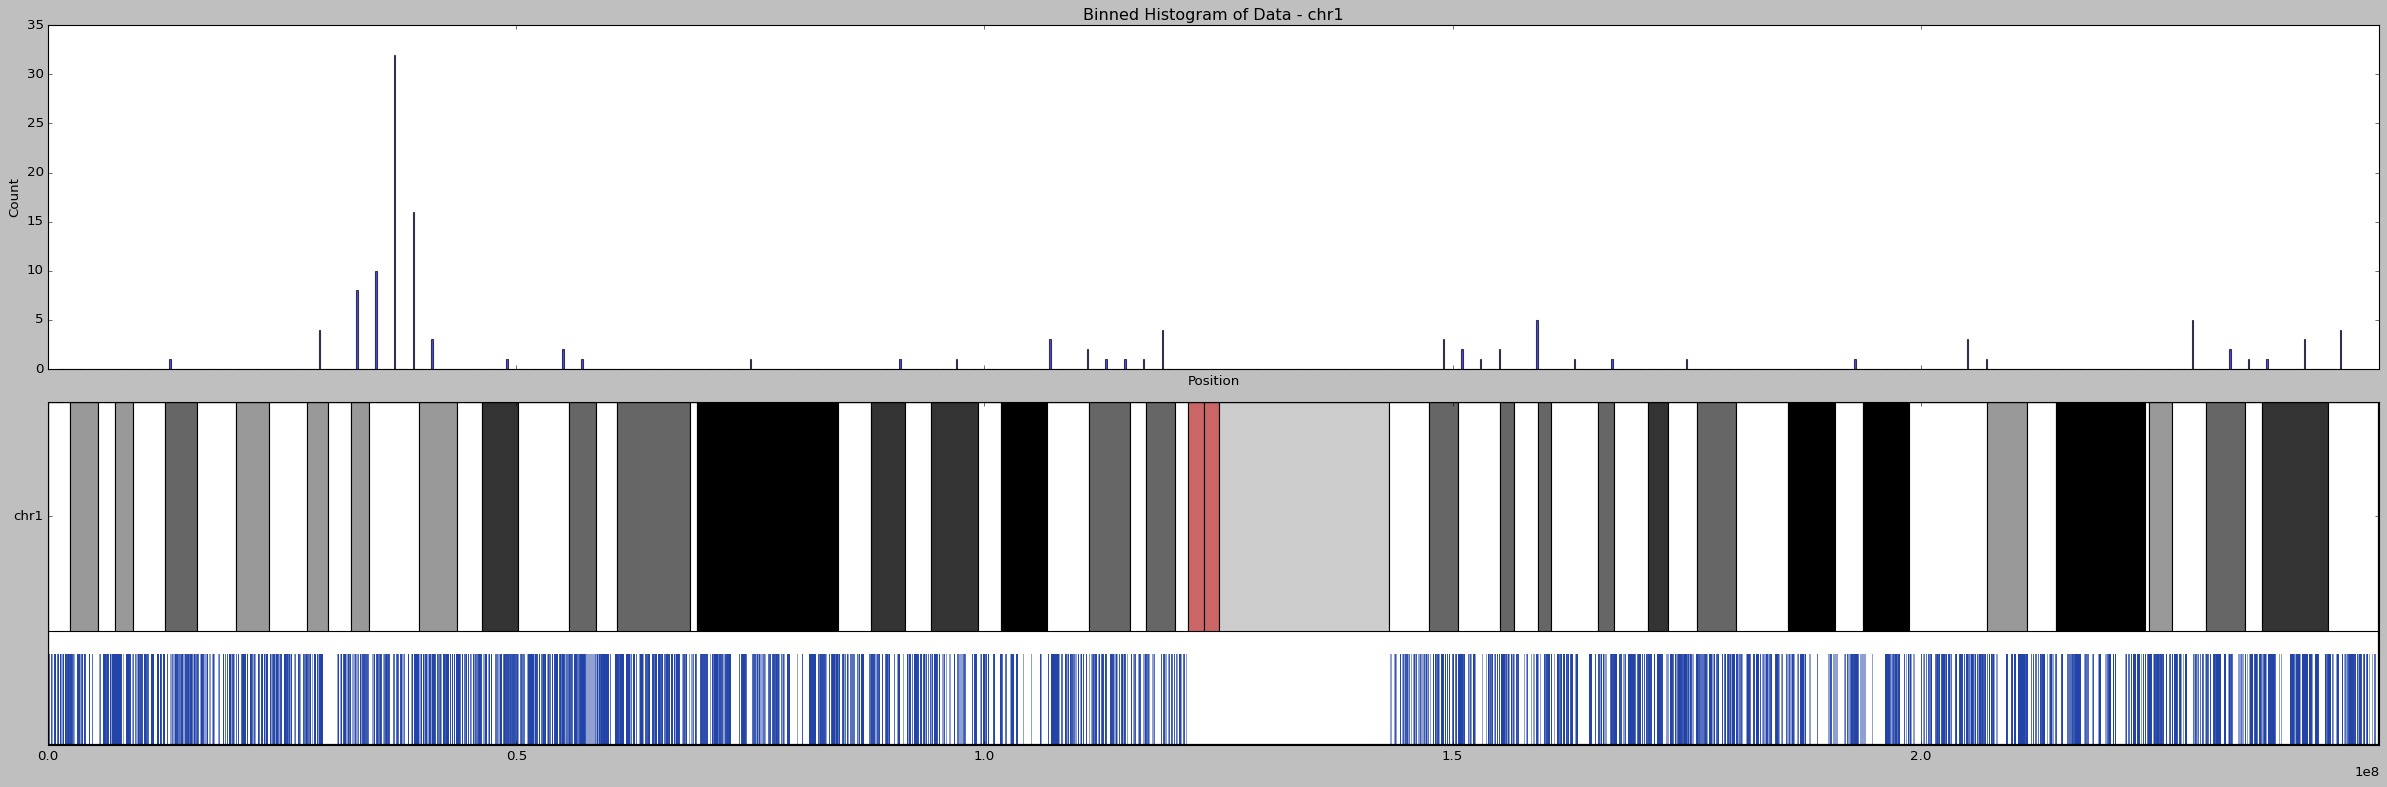

chr2


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


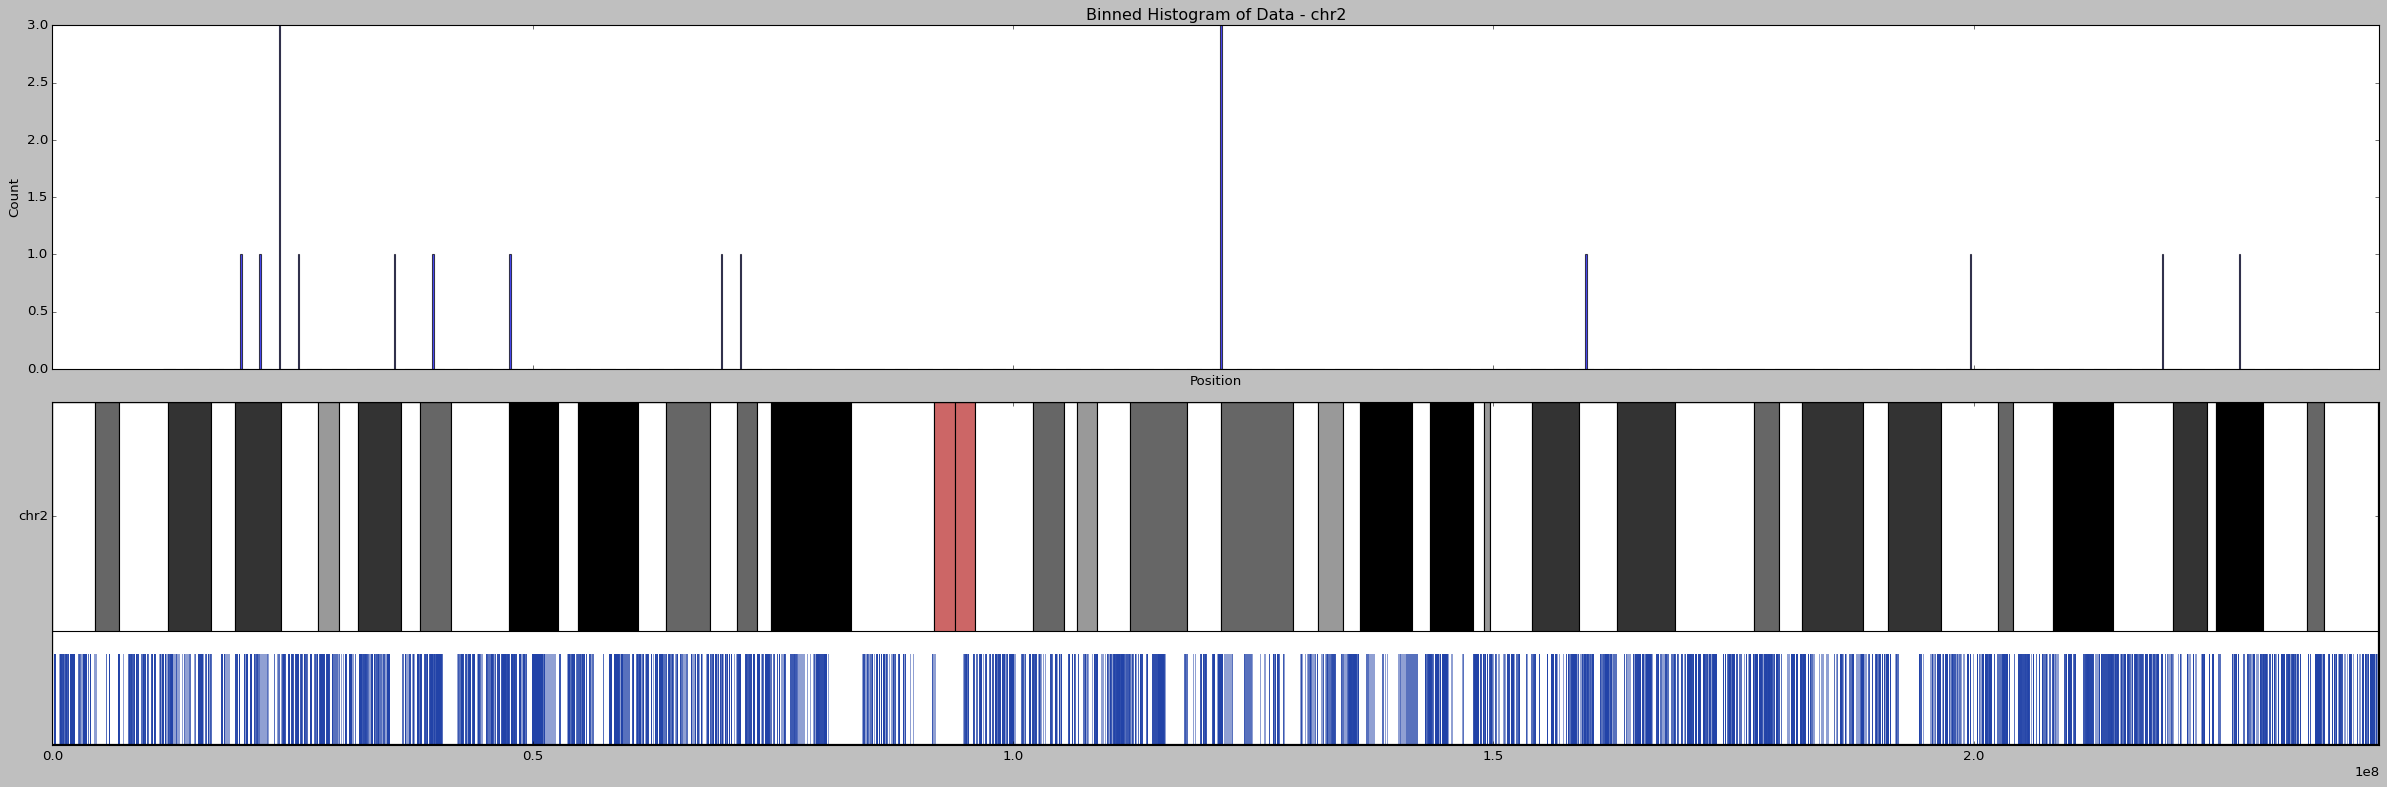

chr3


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


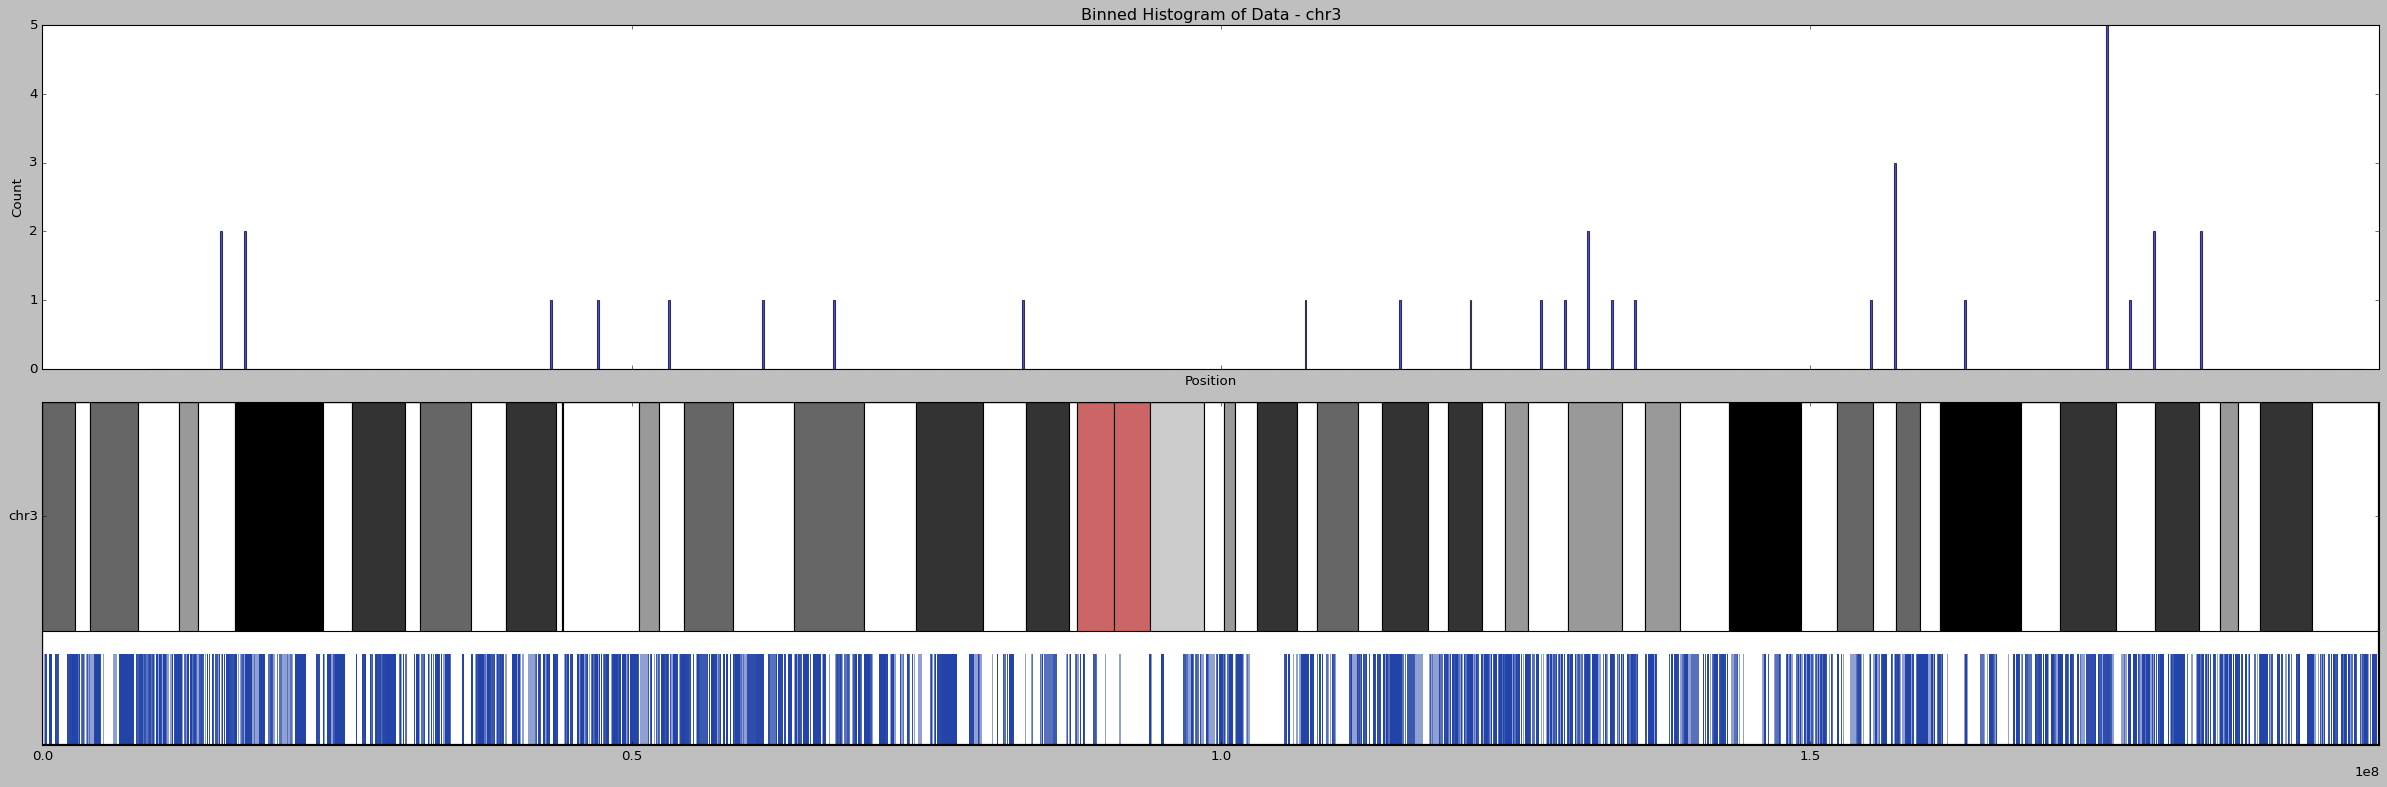

chr4


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


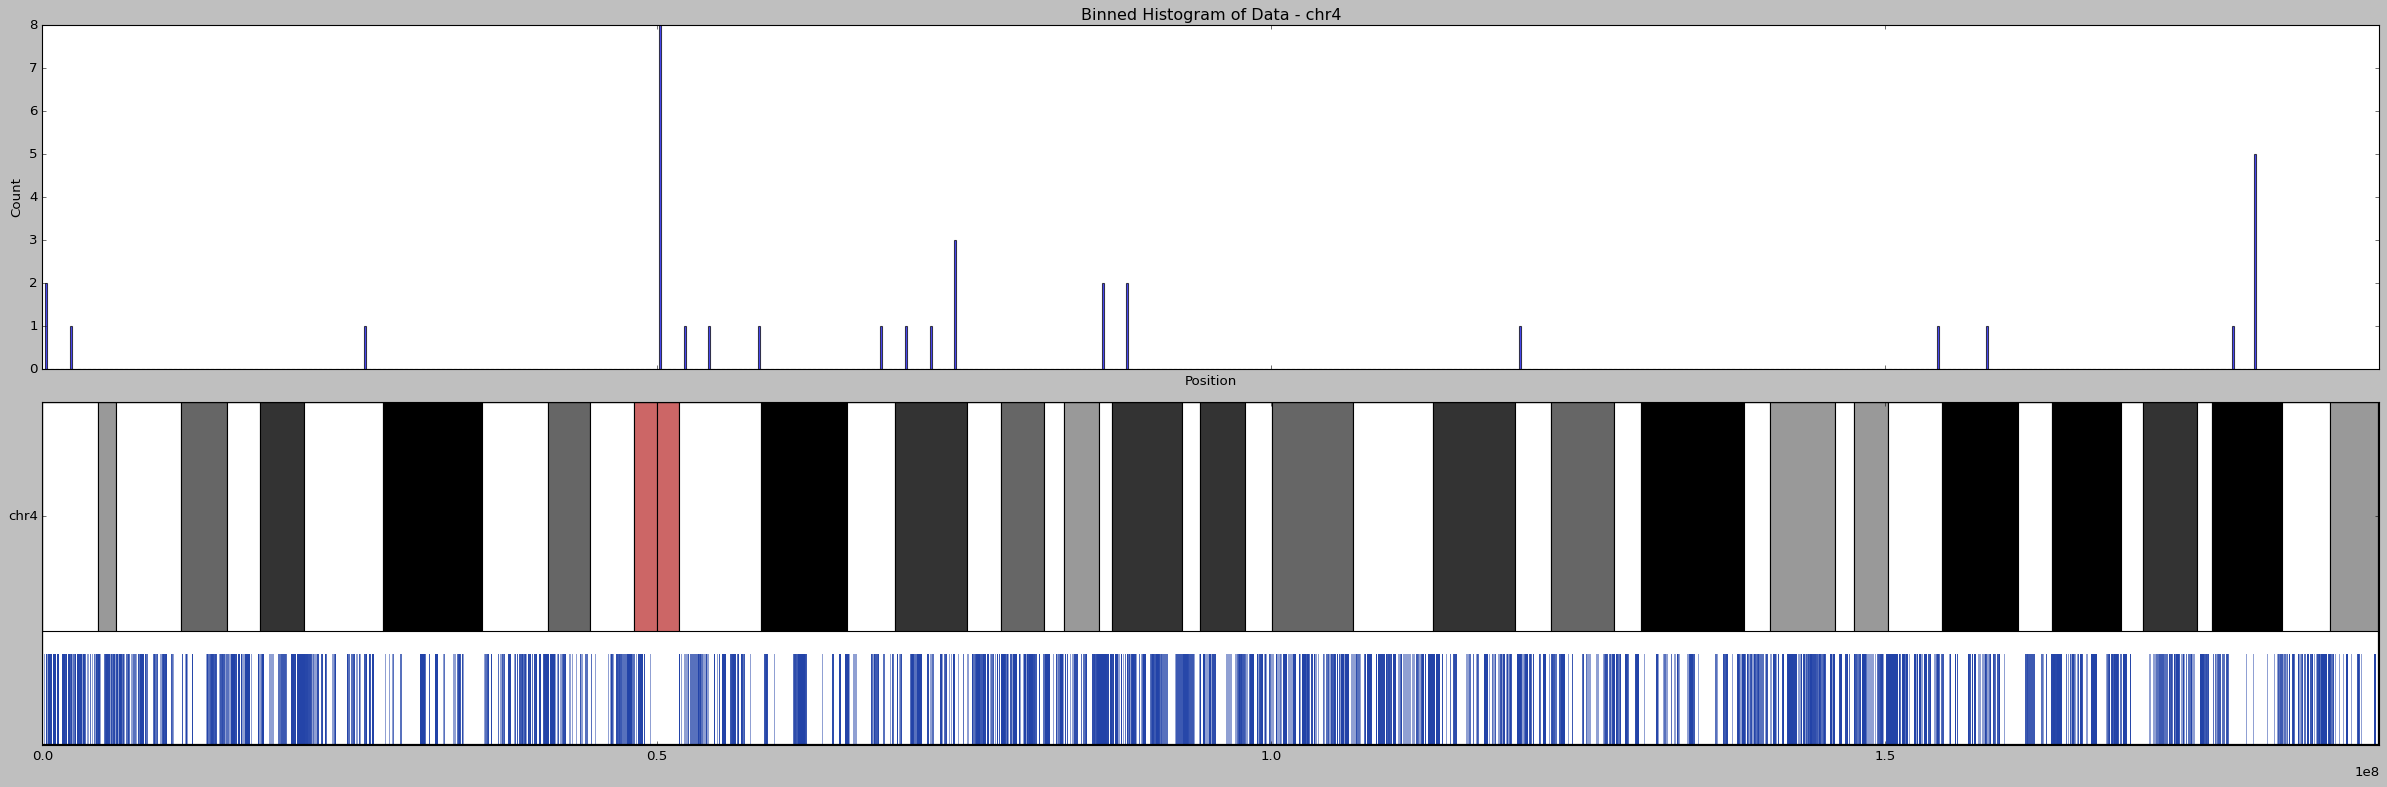

chr5


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


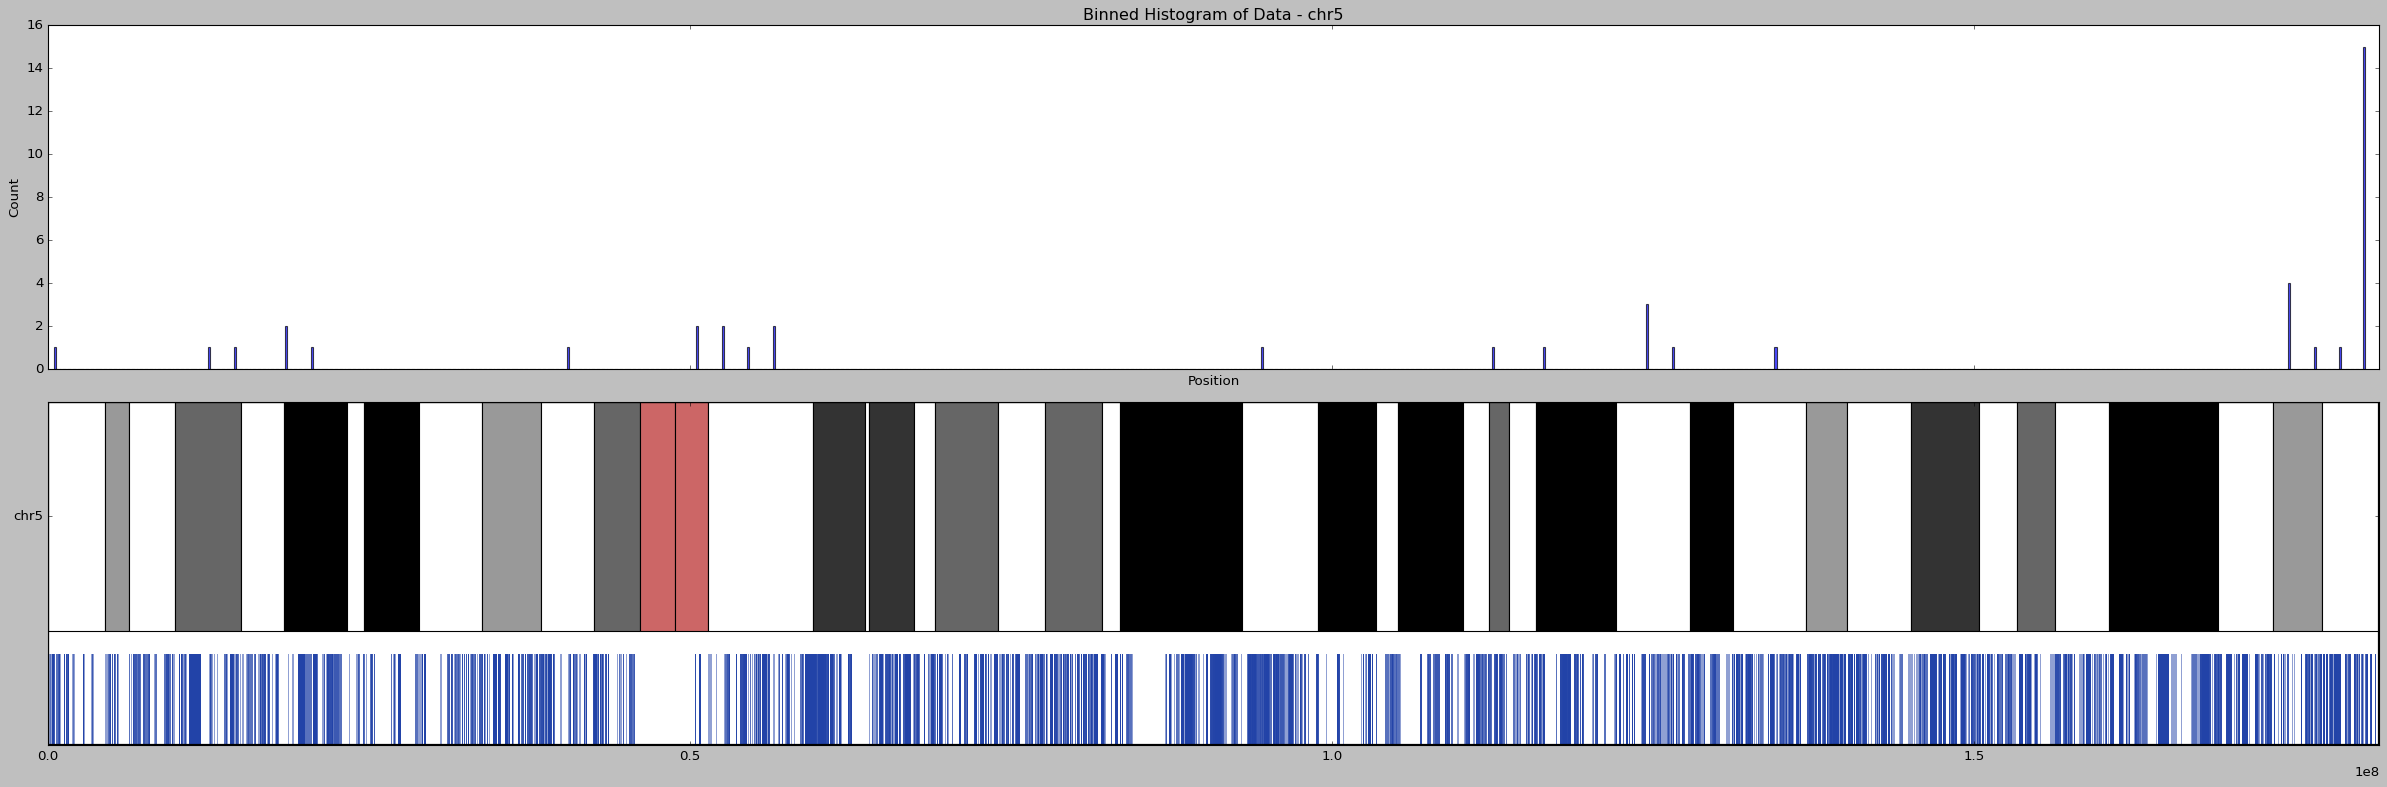

chr6


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


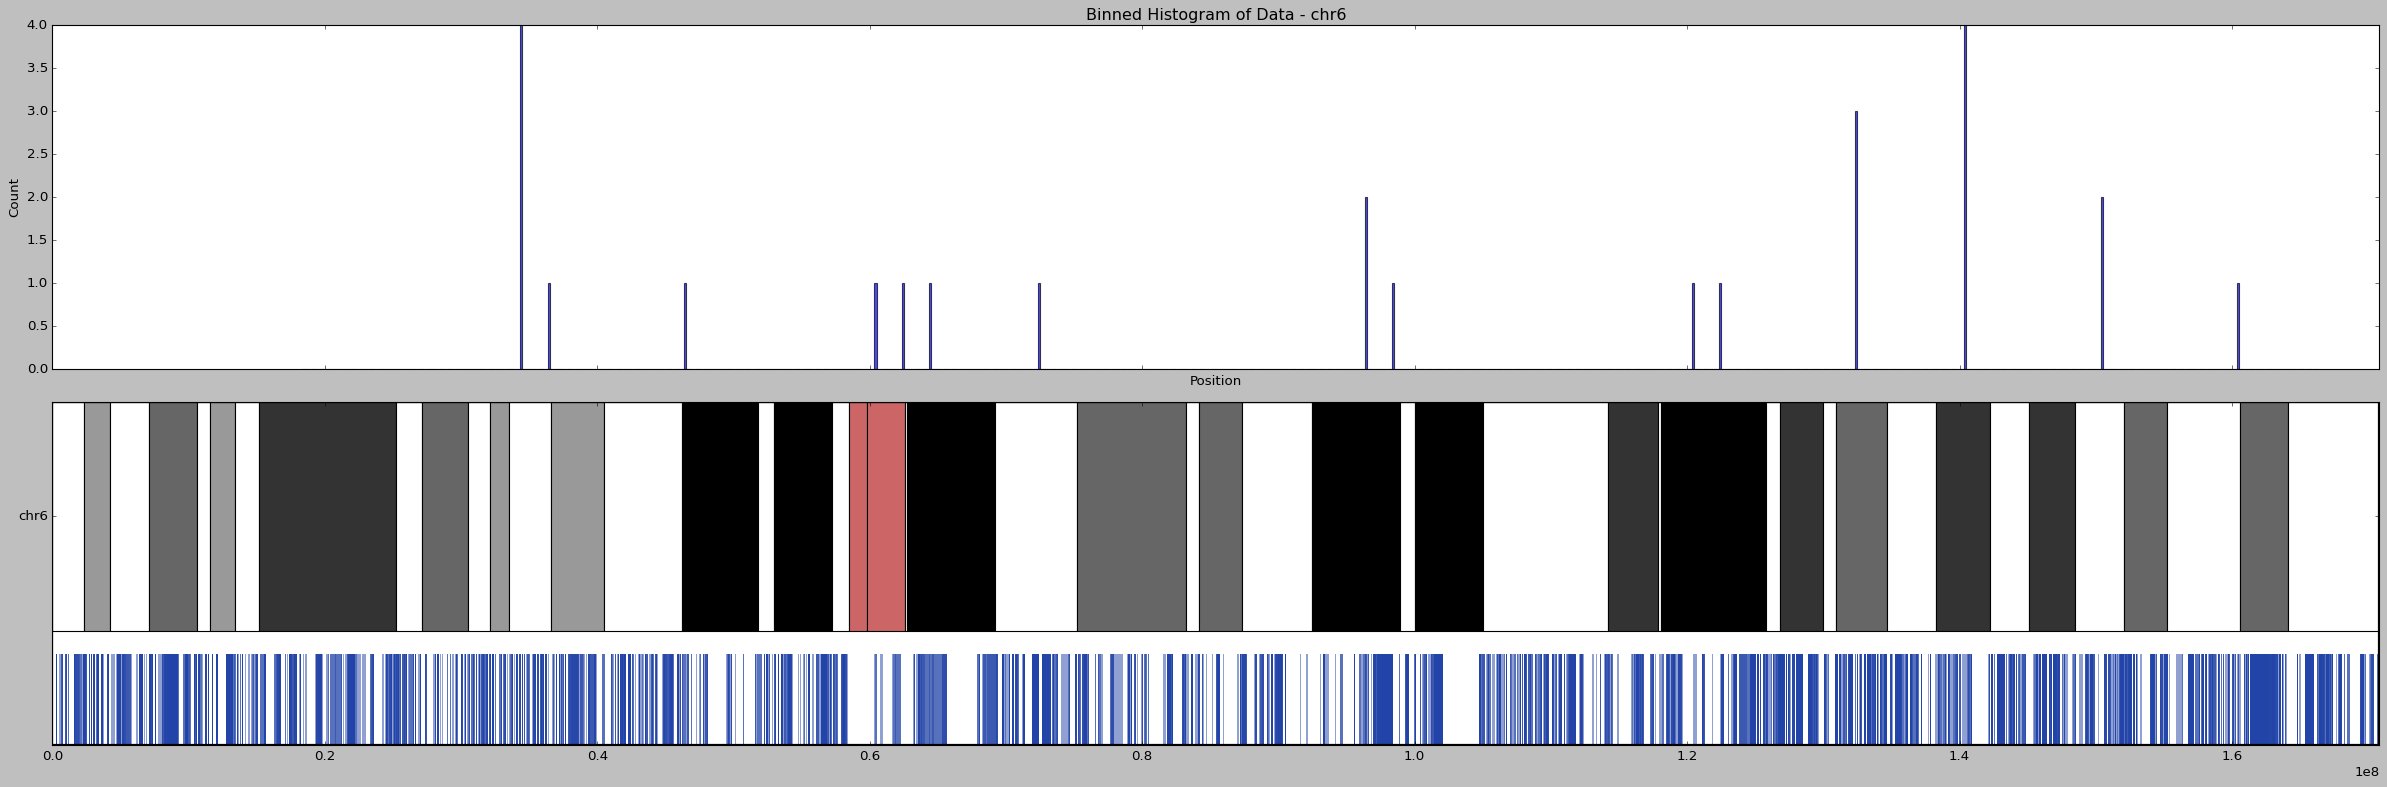

chr7


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


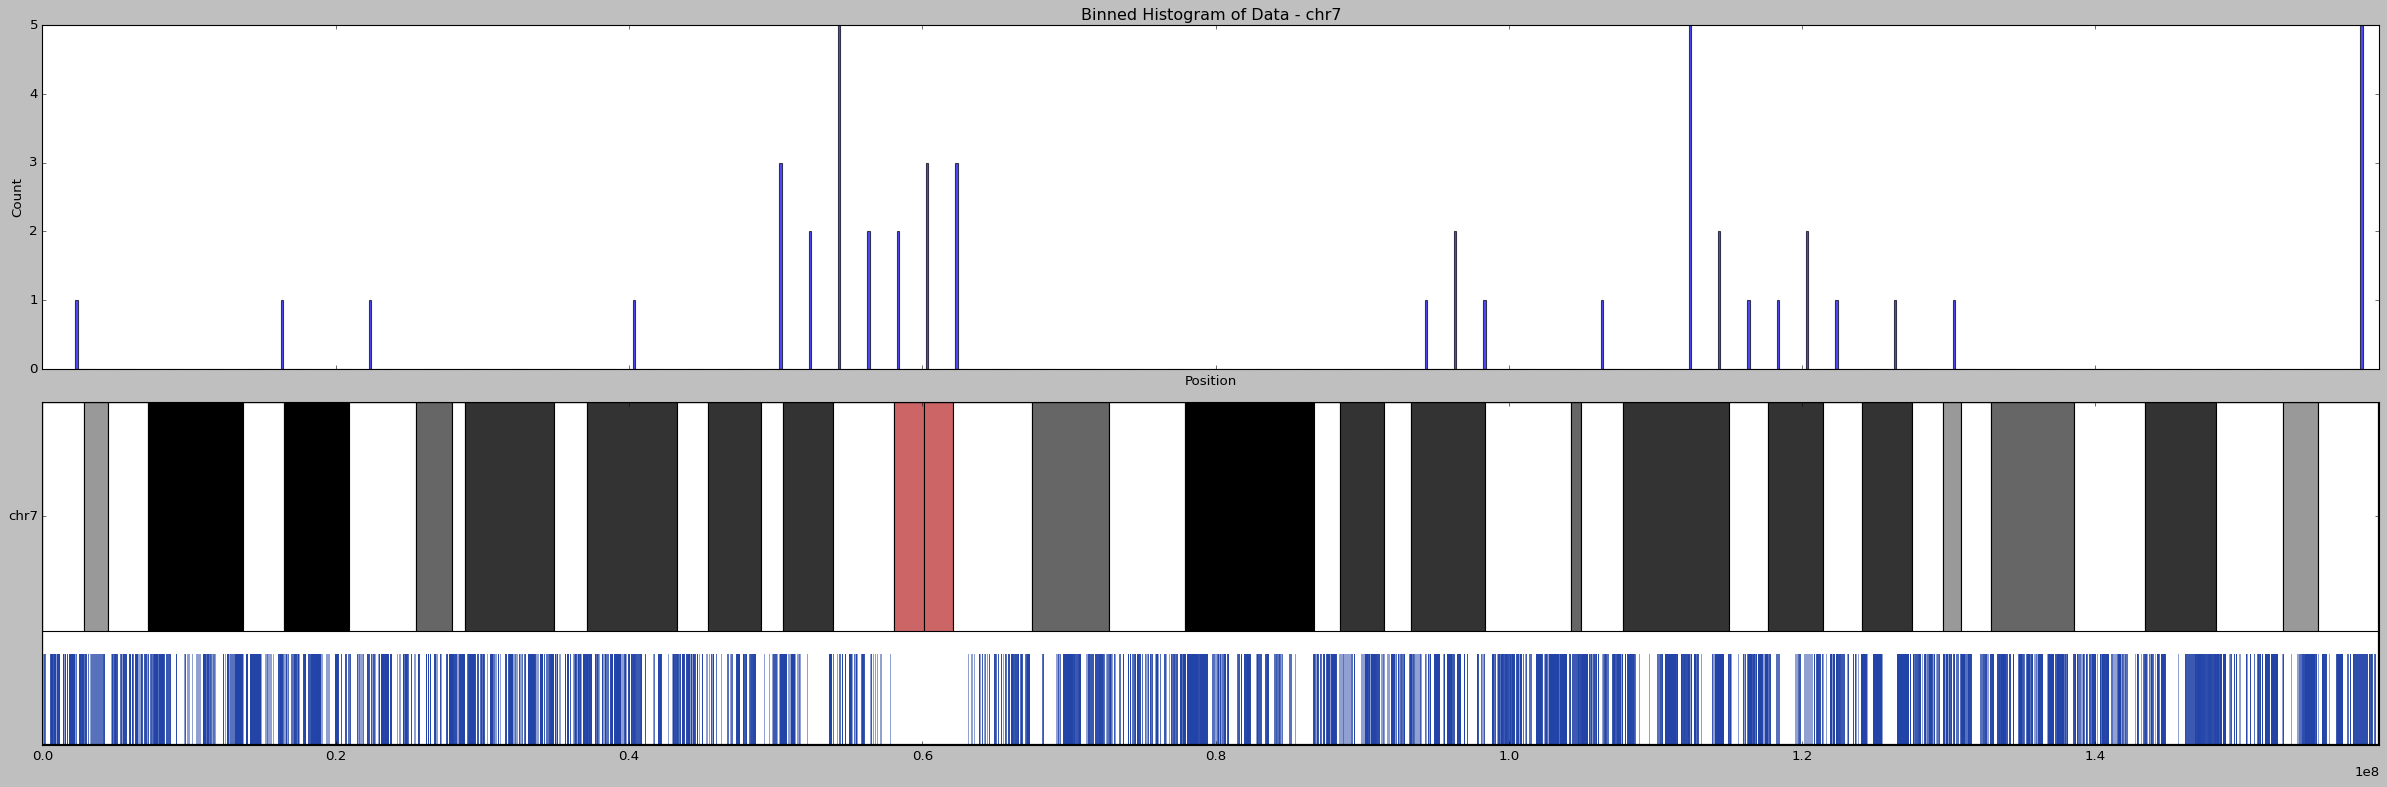

chr8


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


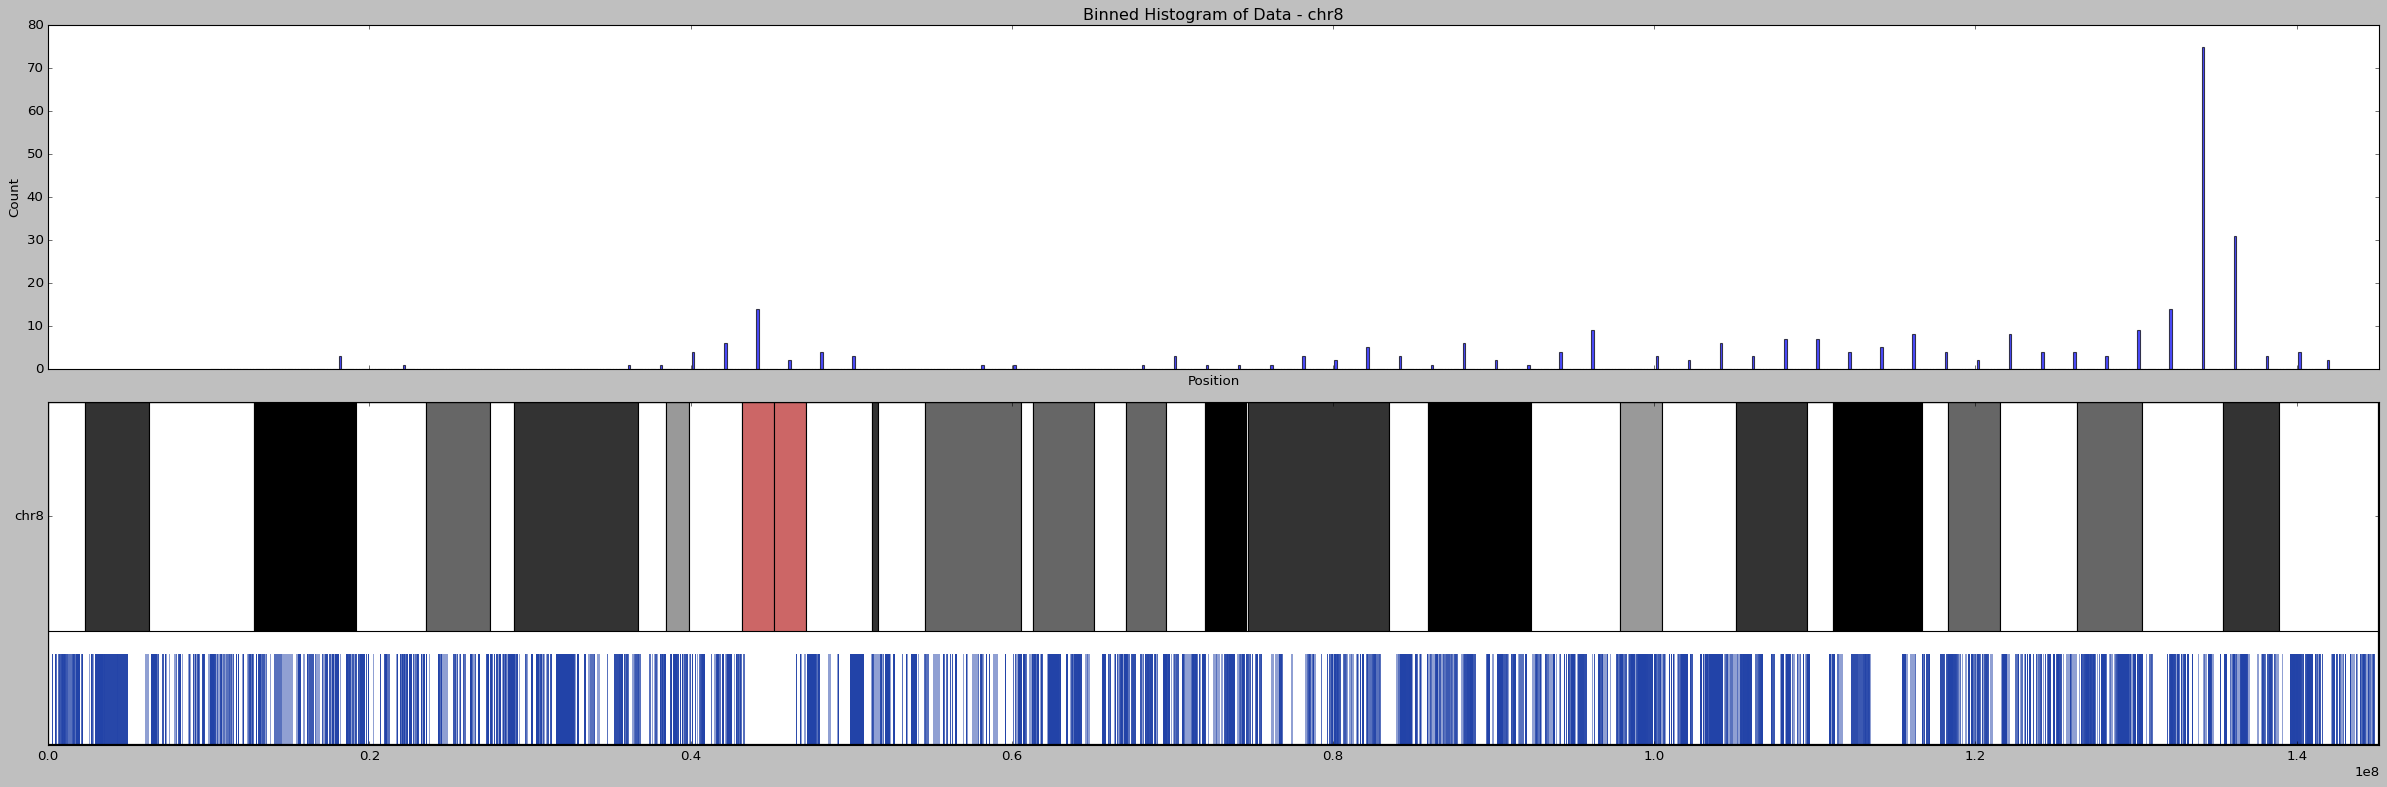

chr9


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


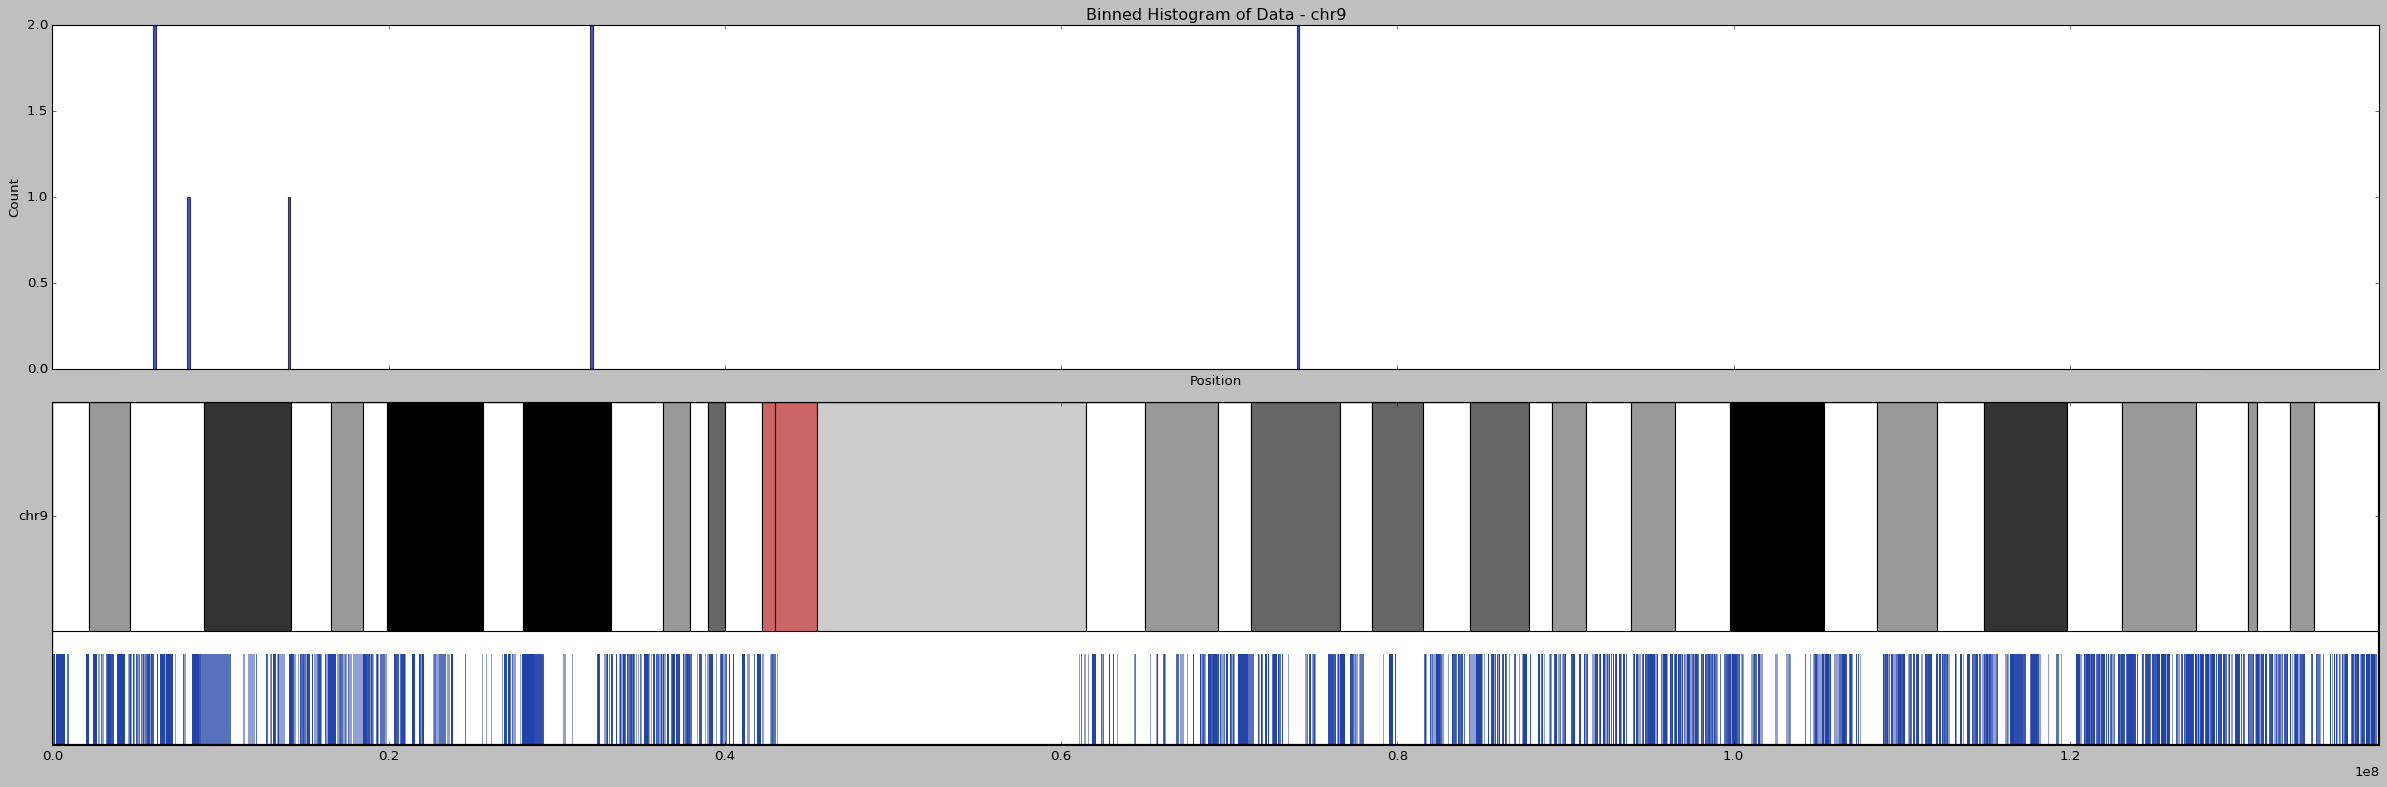

chr10


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


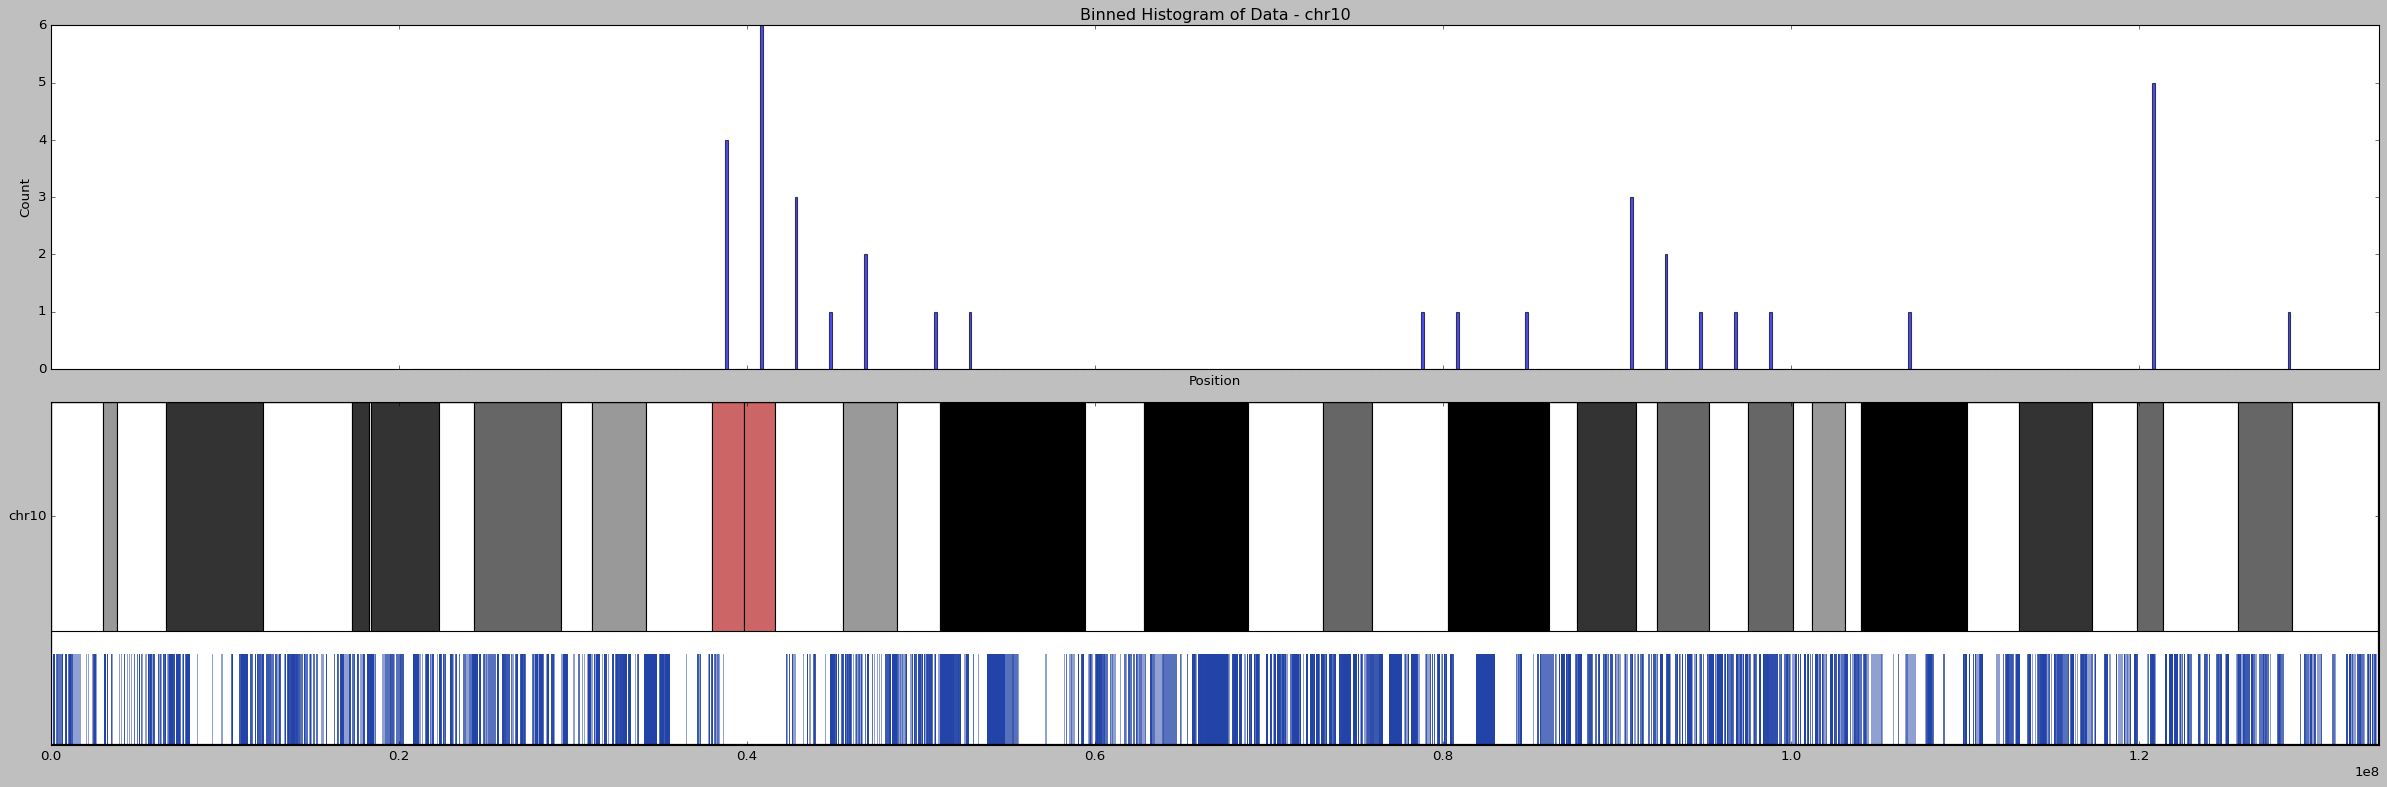

chr11


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


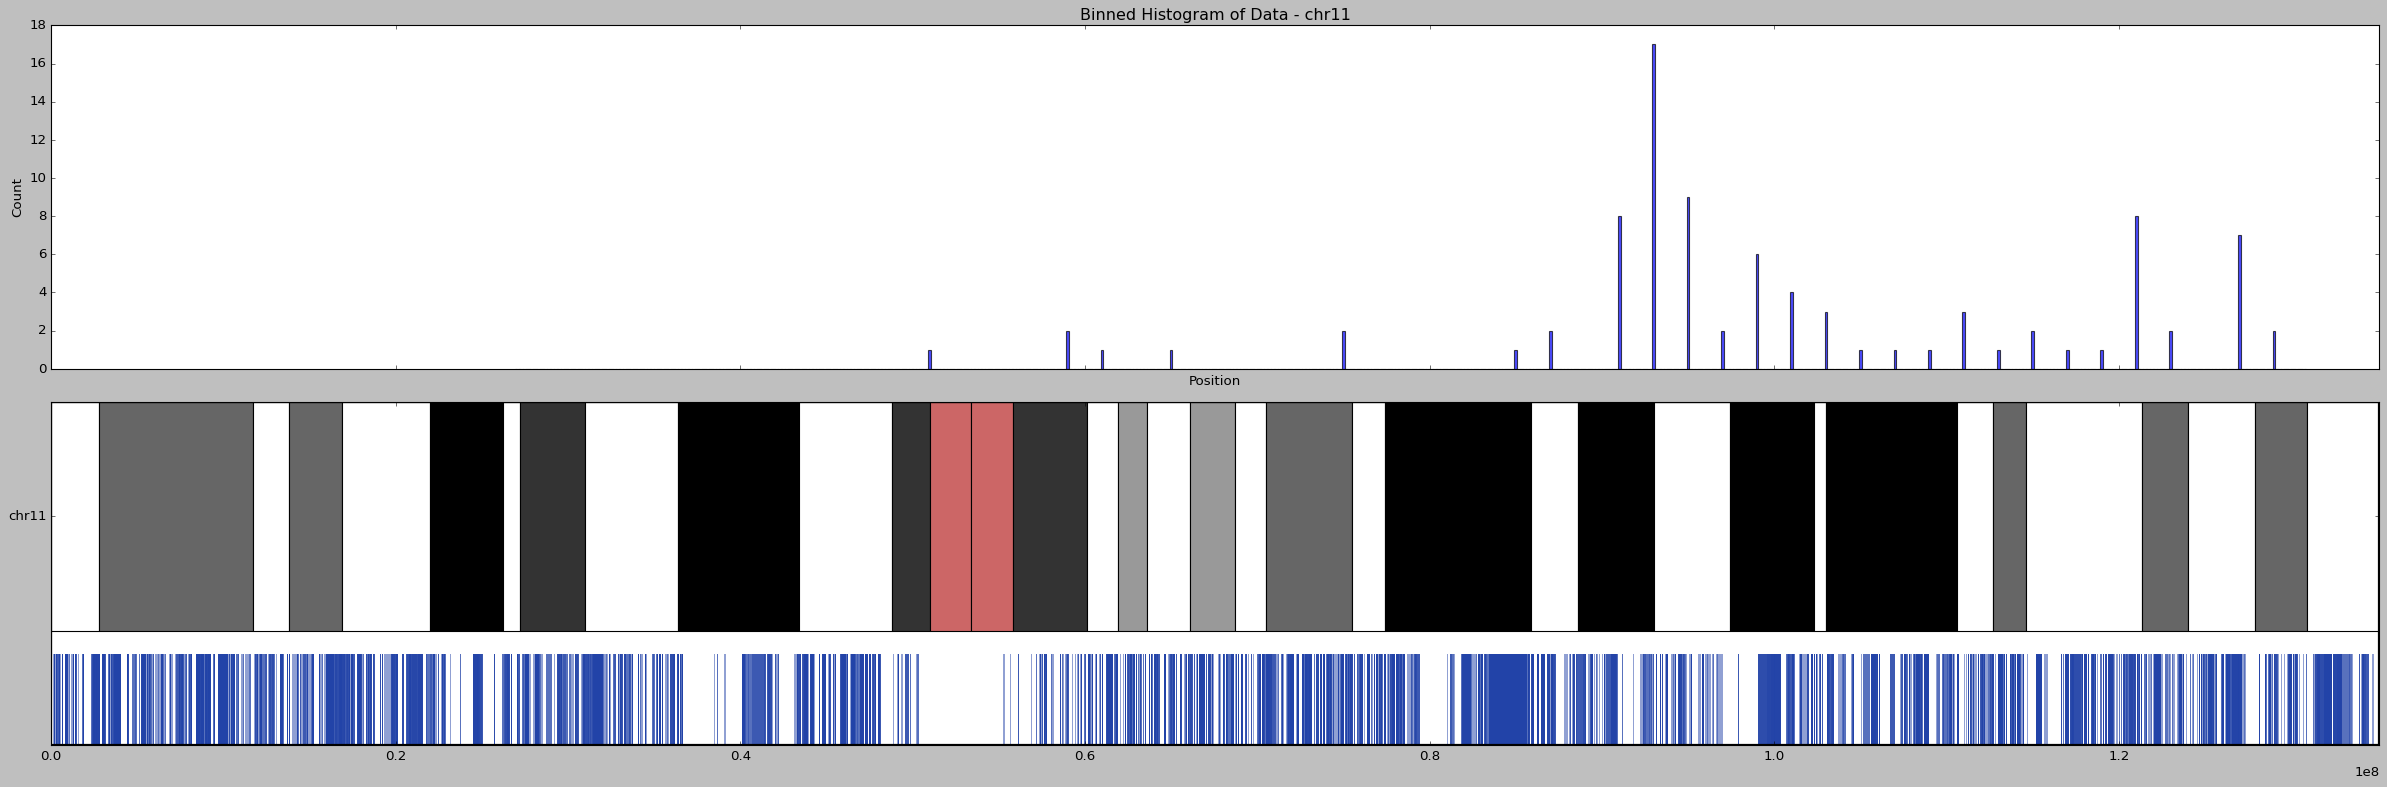

chr12


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


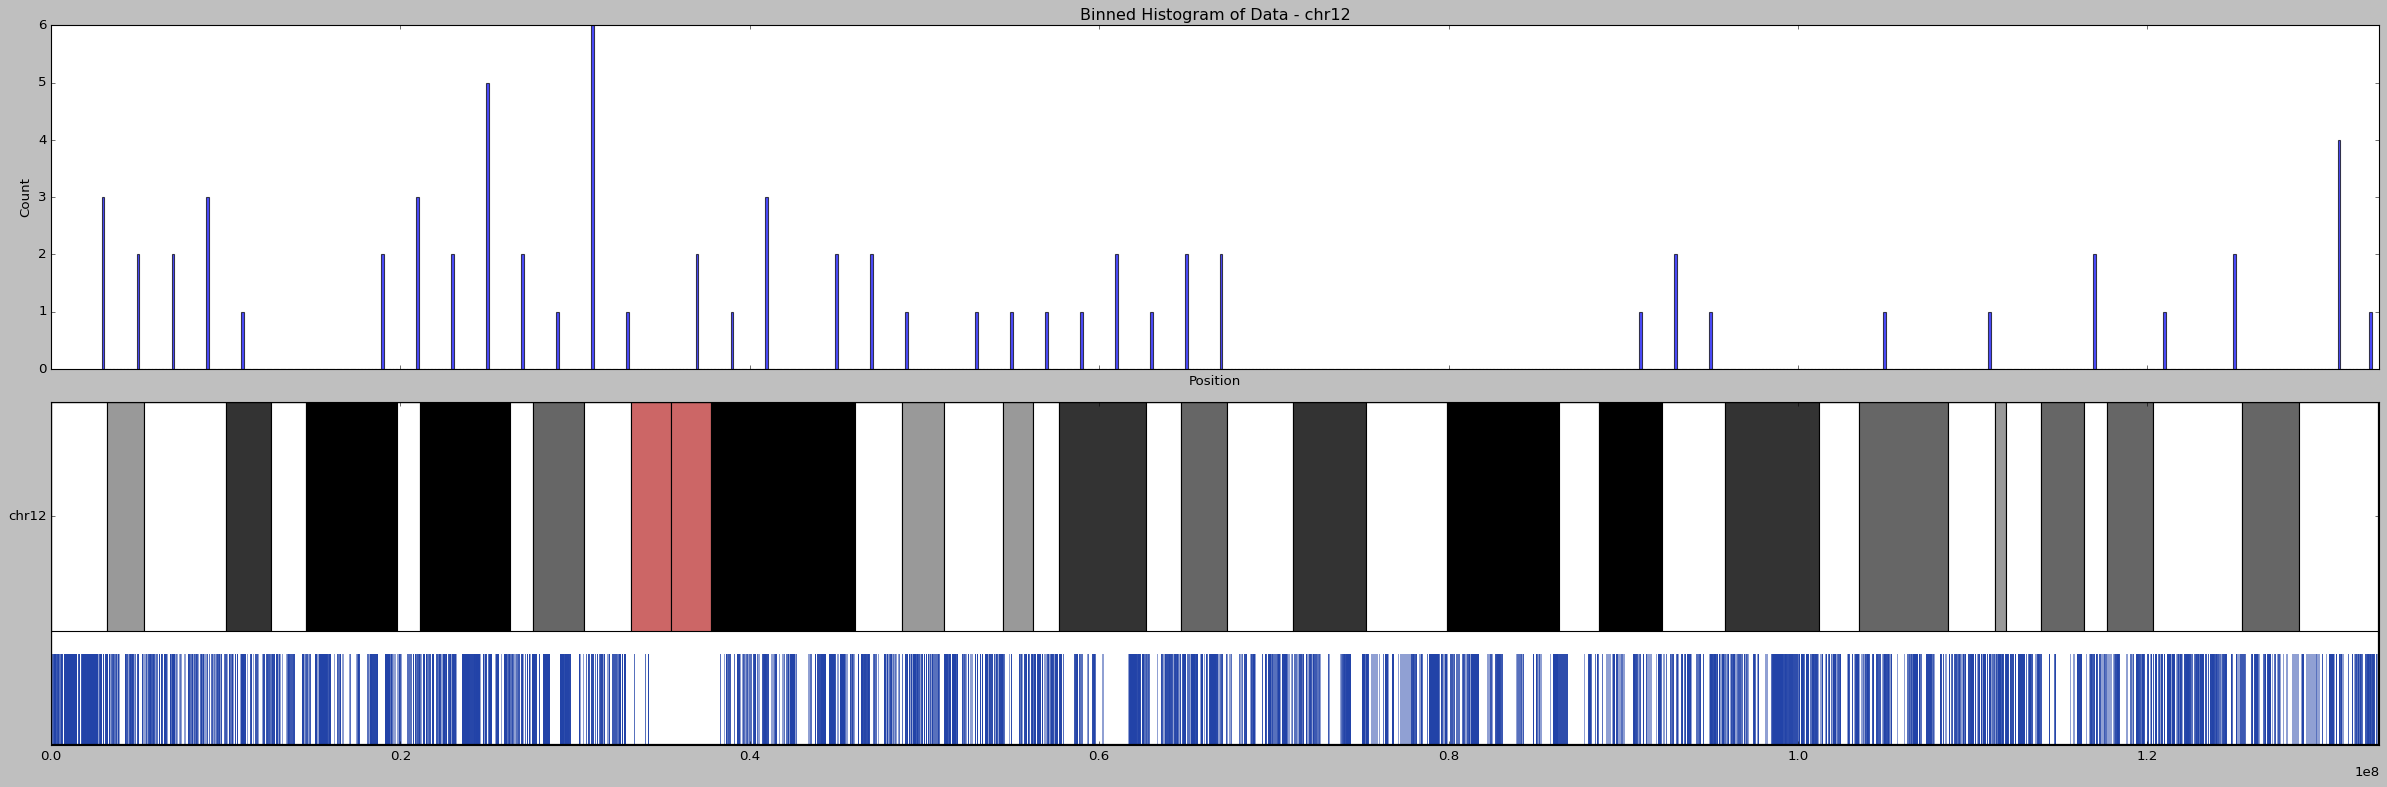

chr13


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


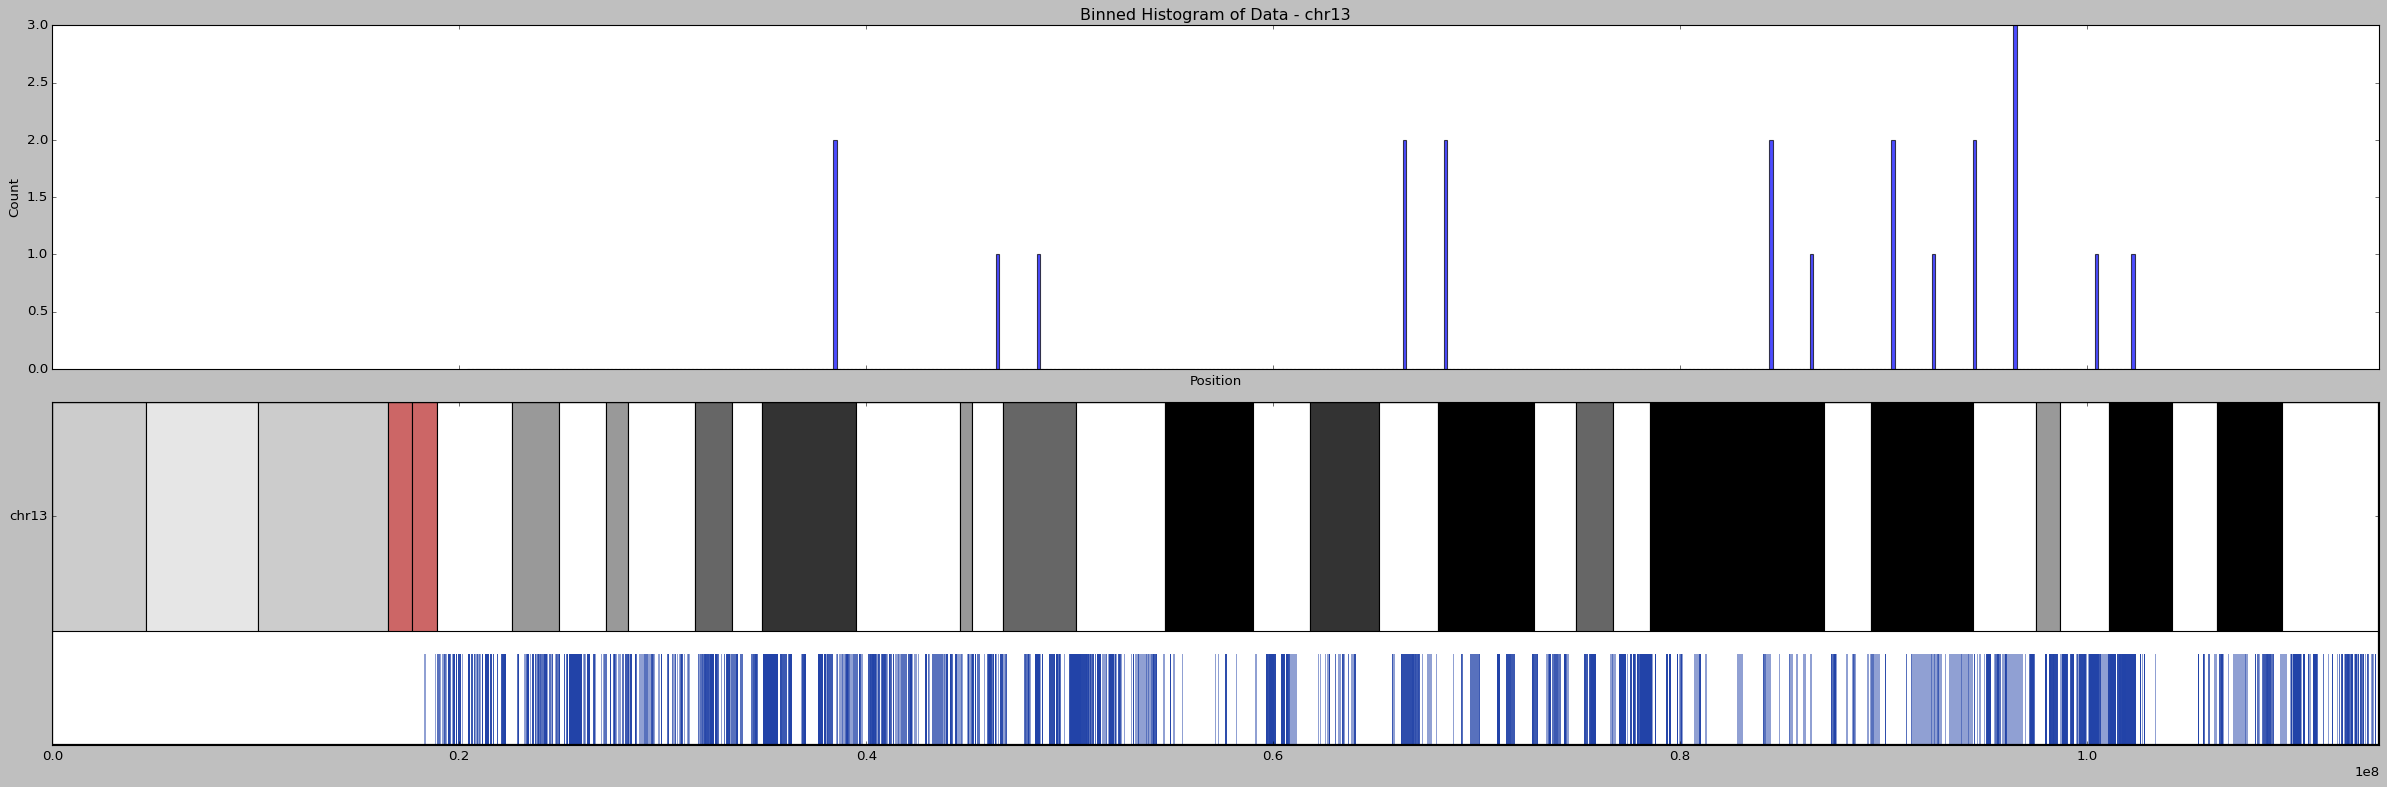

chr14


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


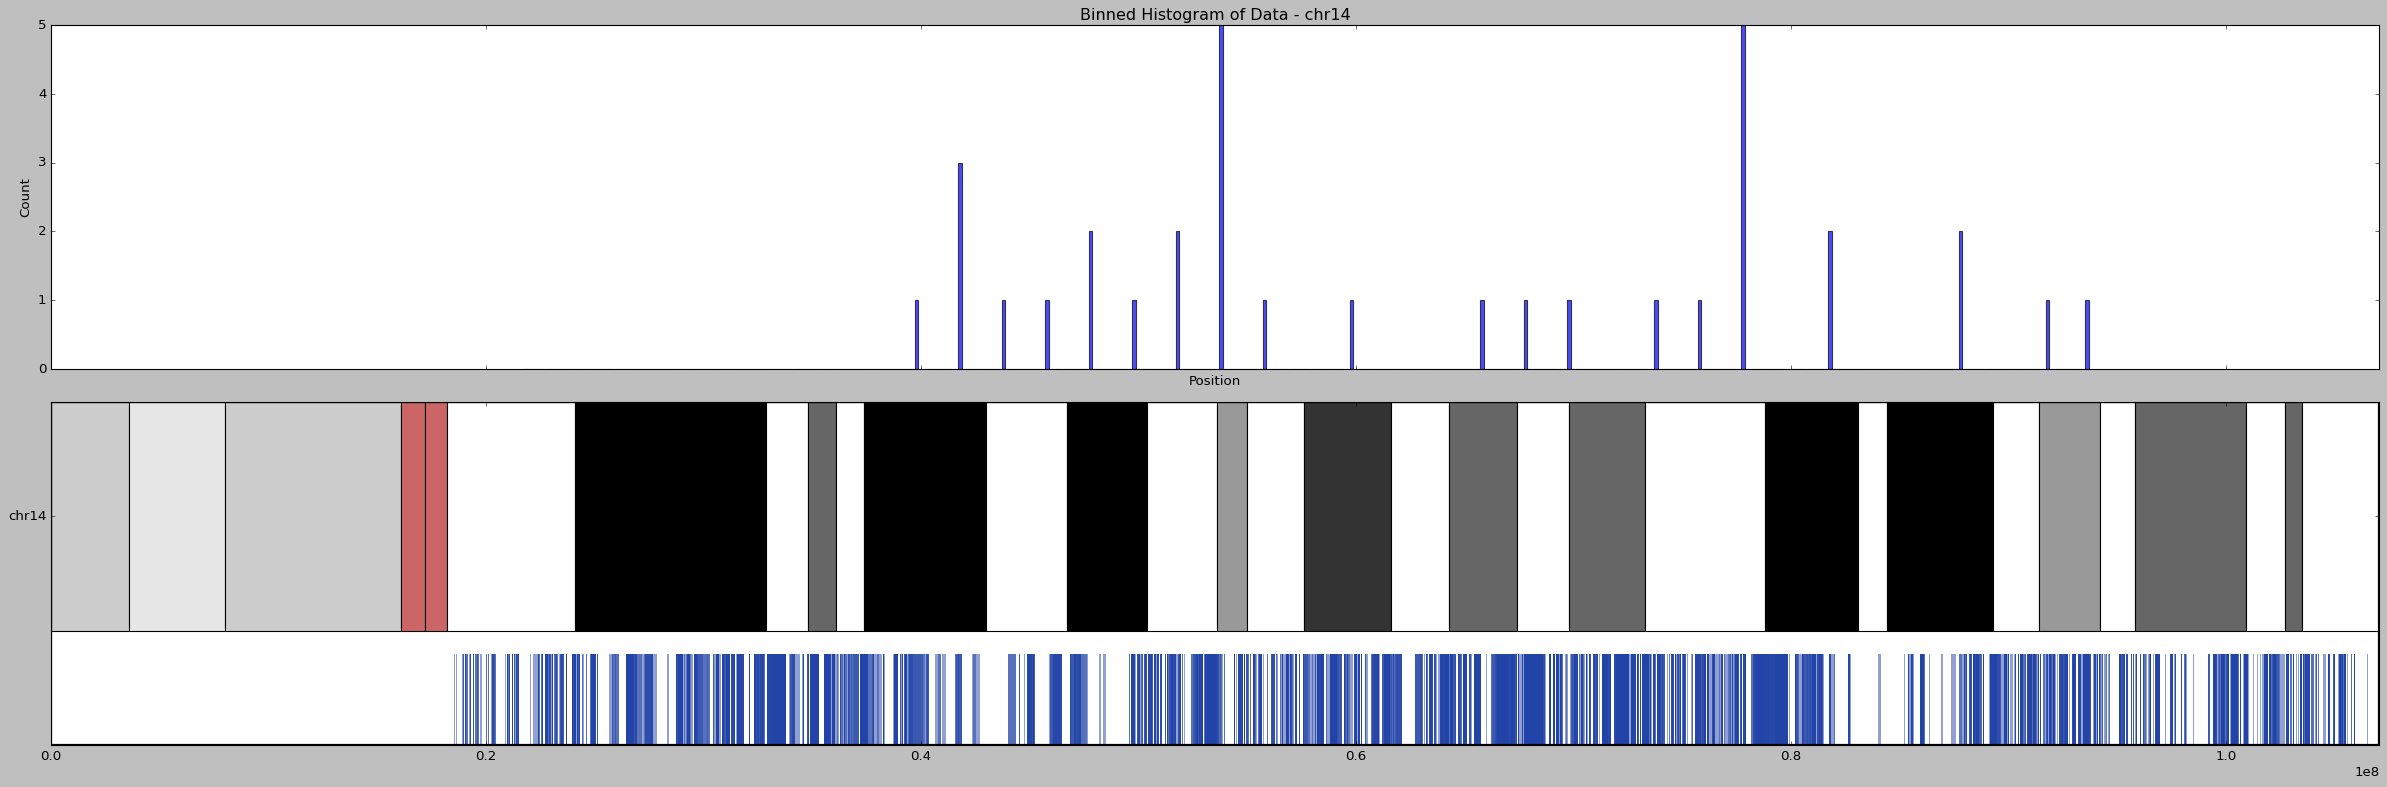

chr15


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


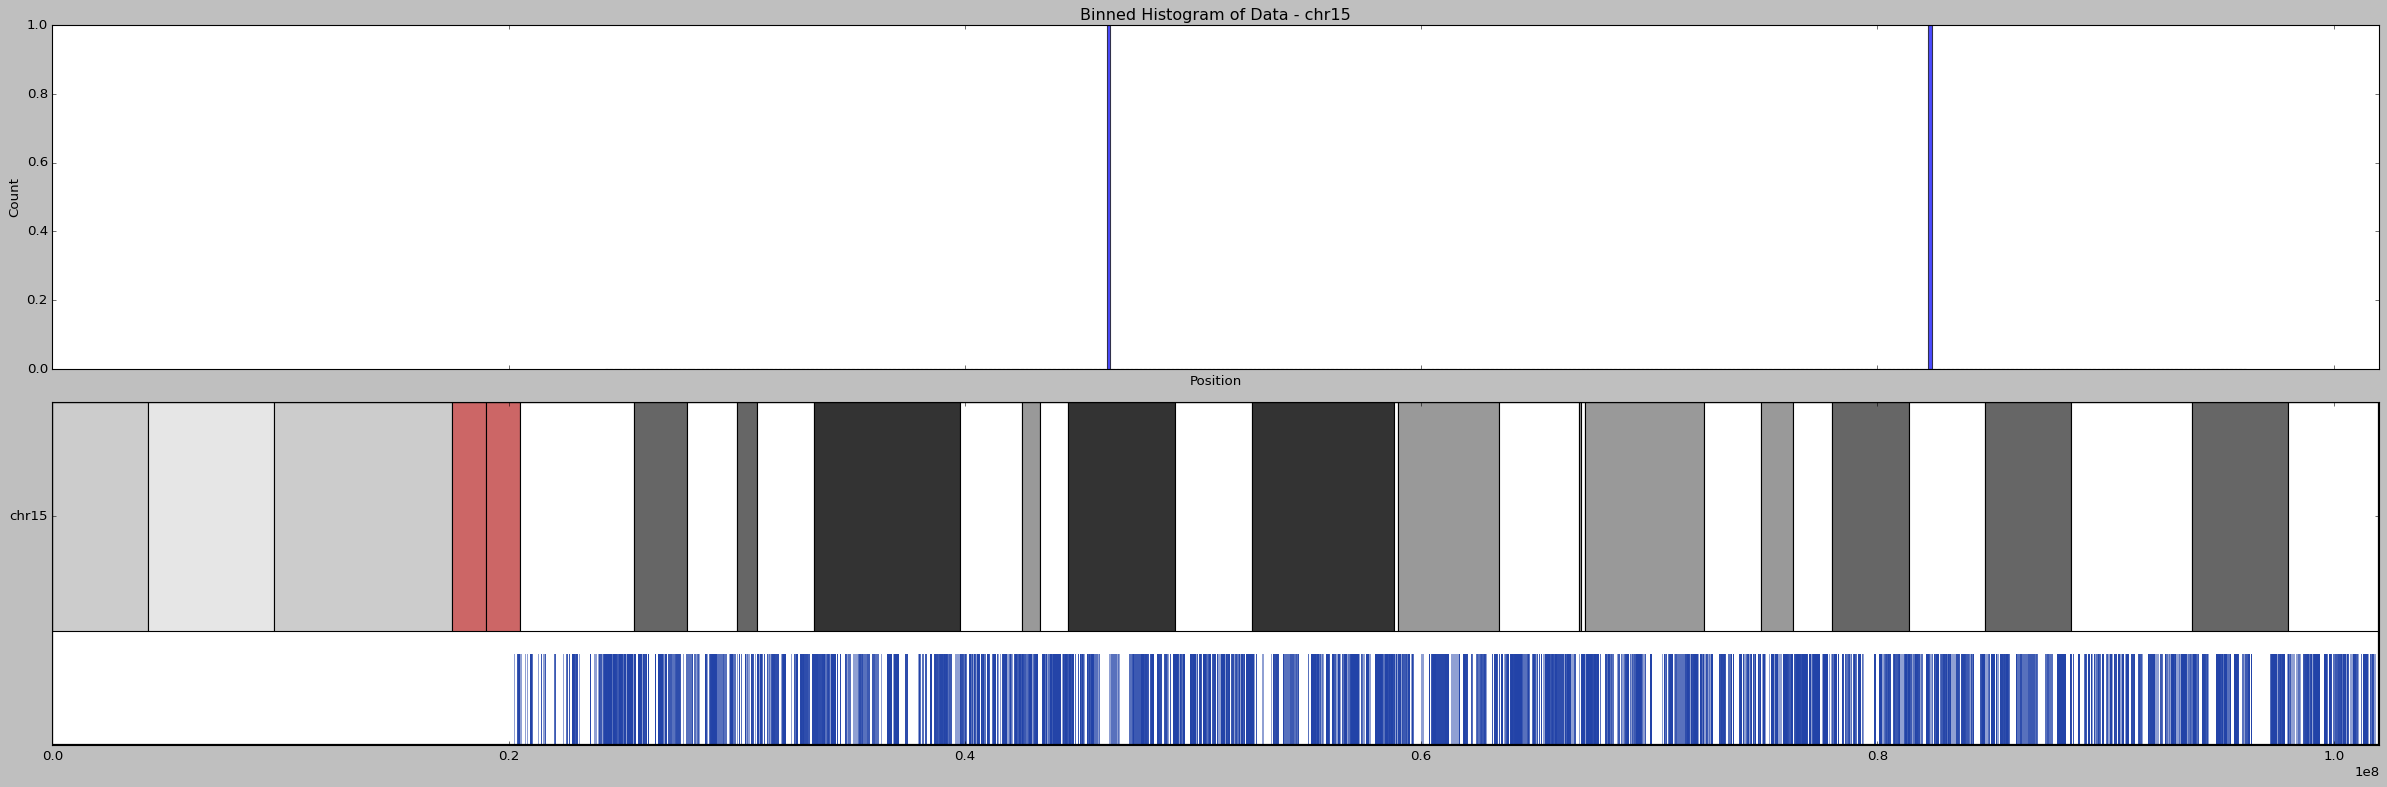

chr16


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


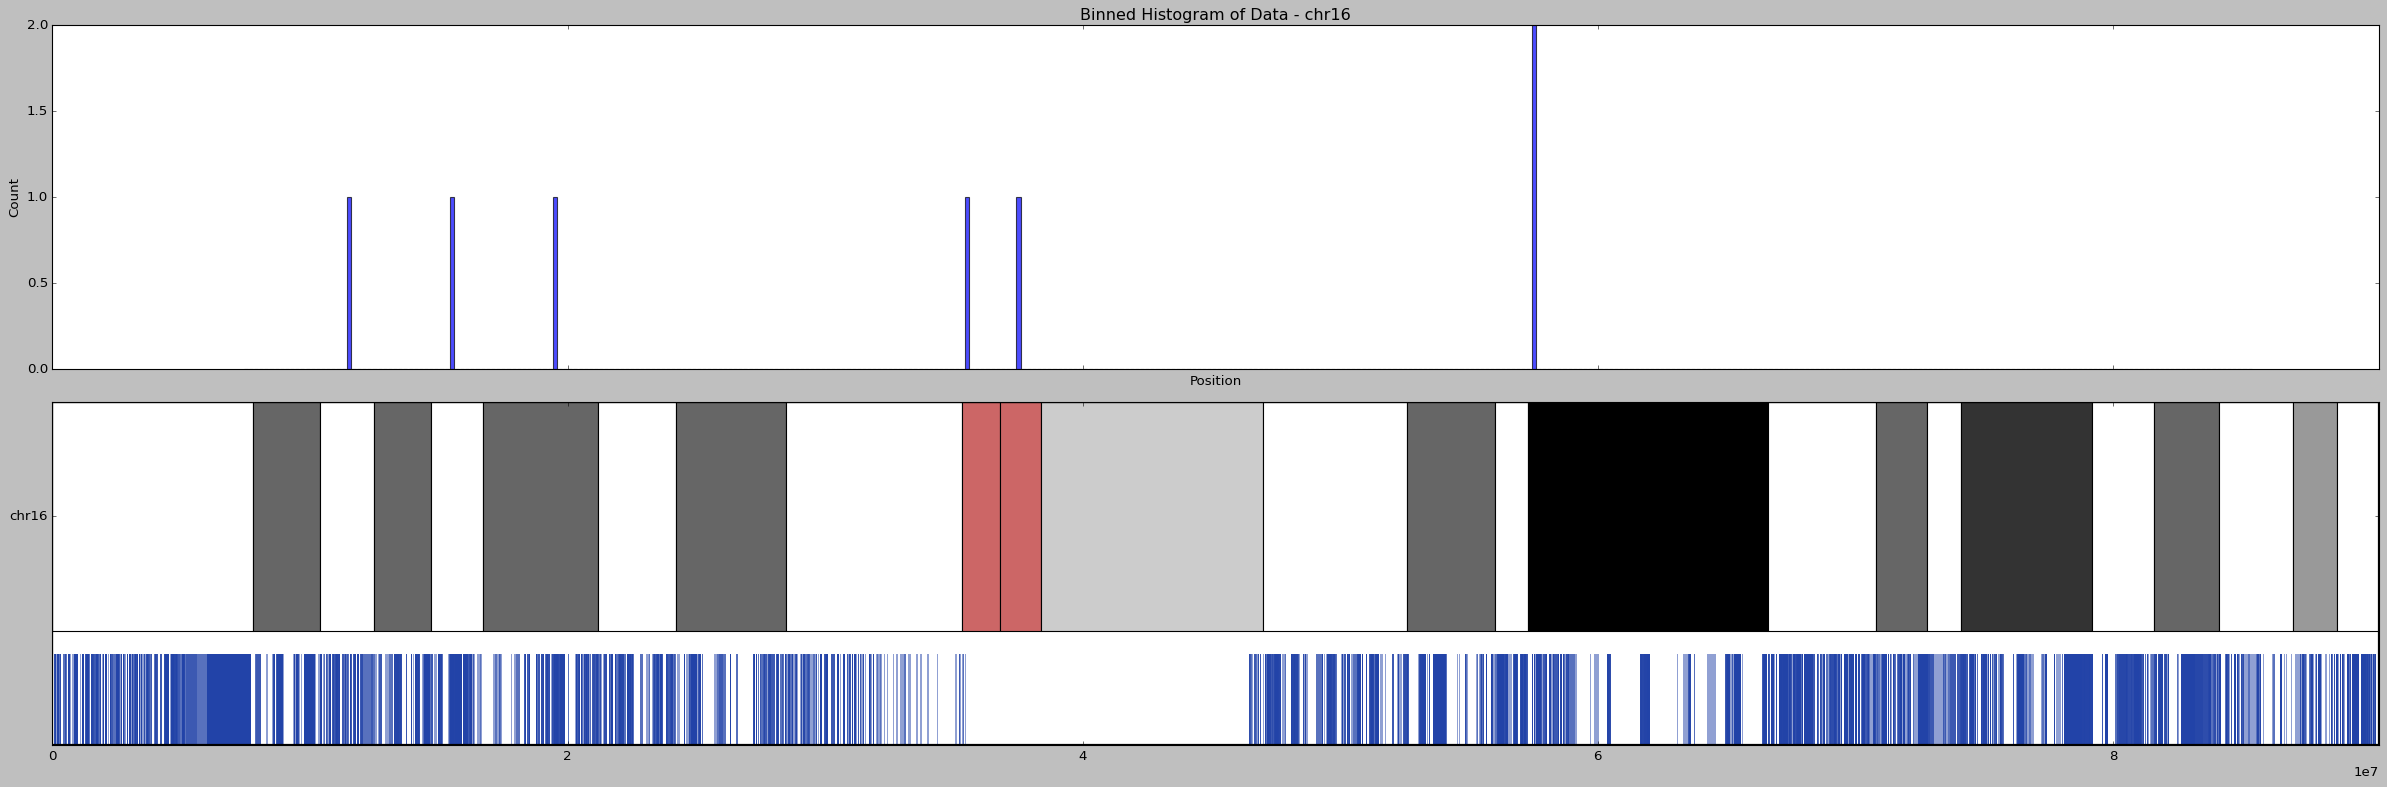

chr17


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


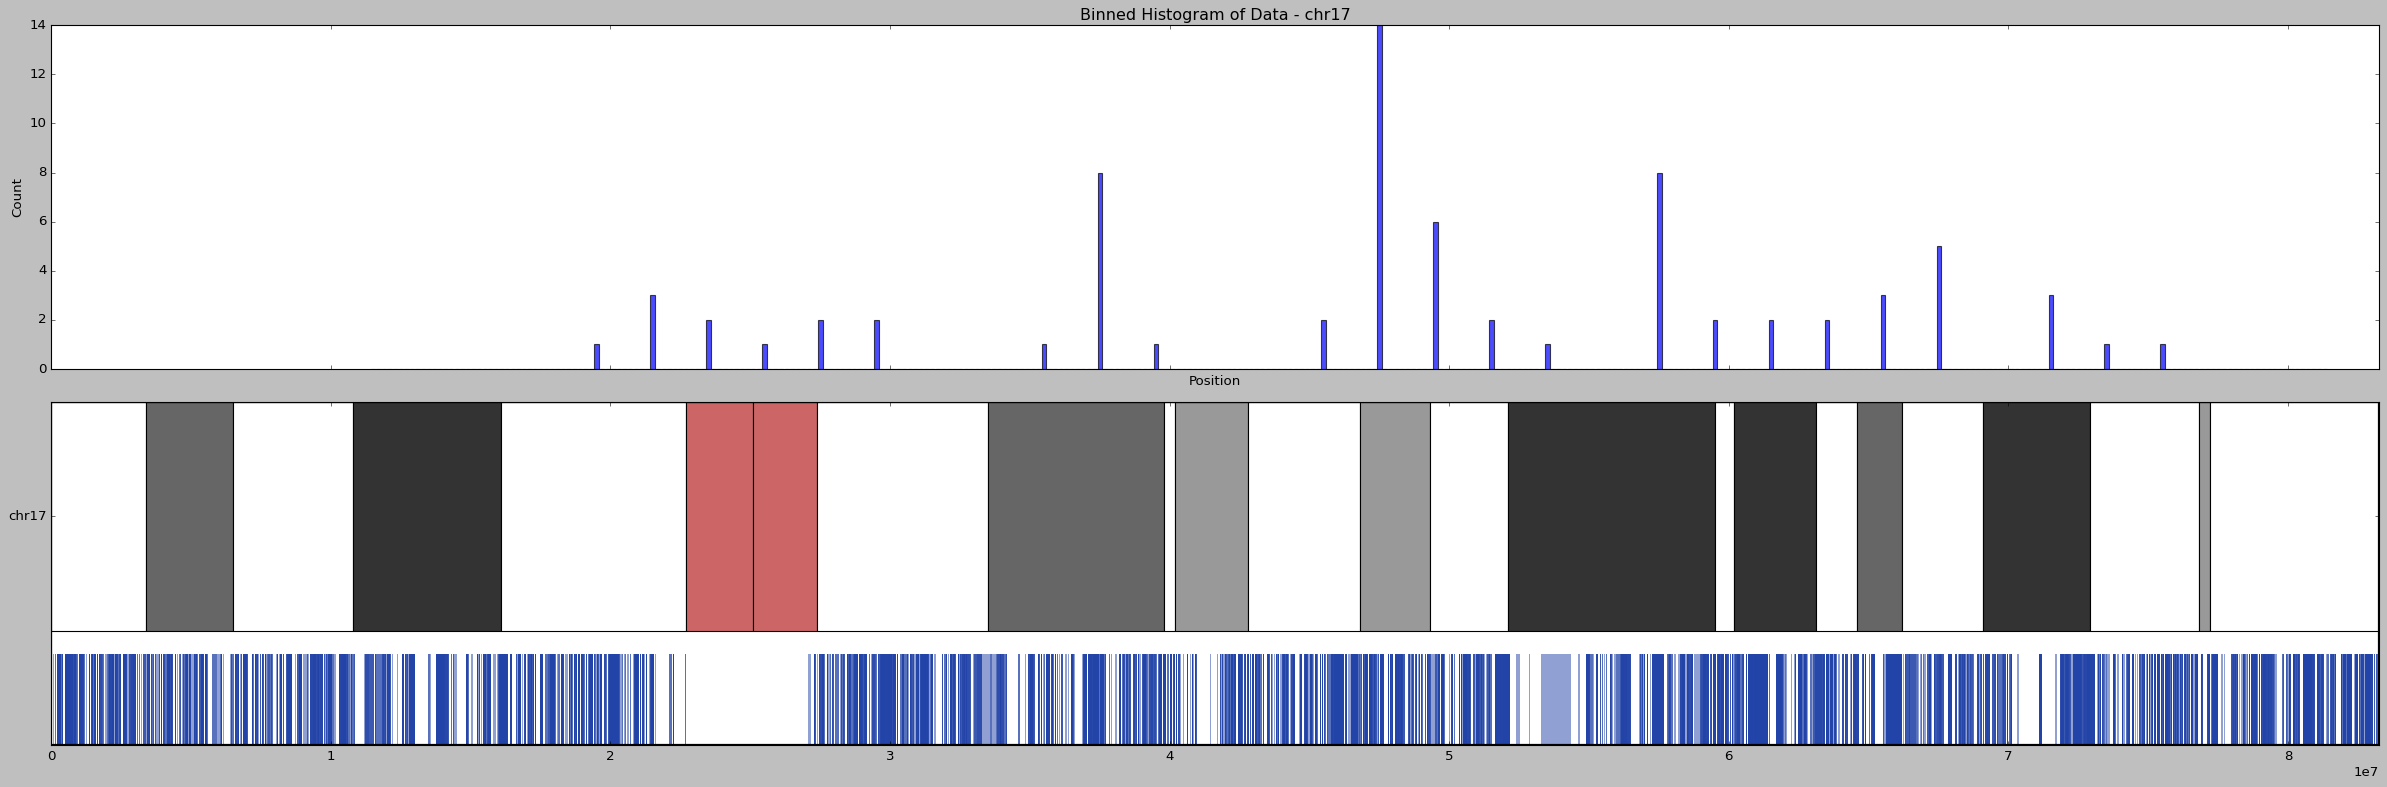

chr18


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


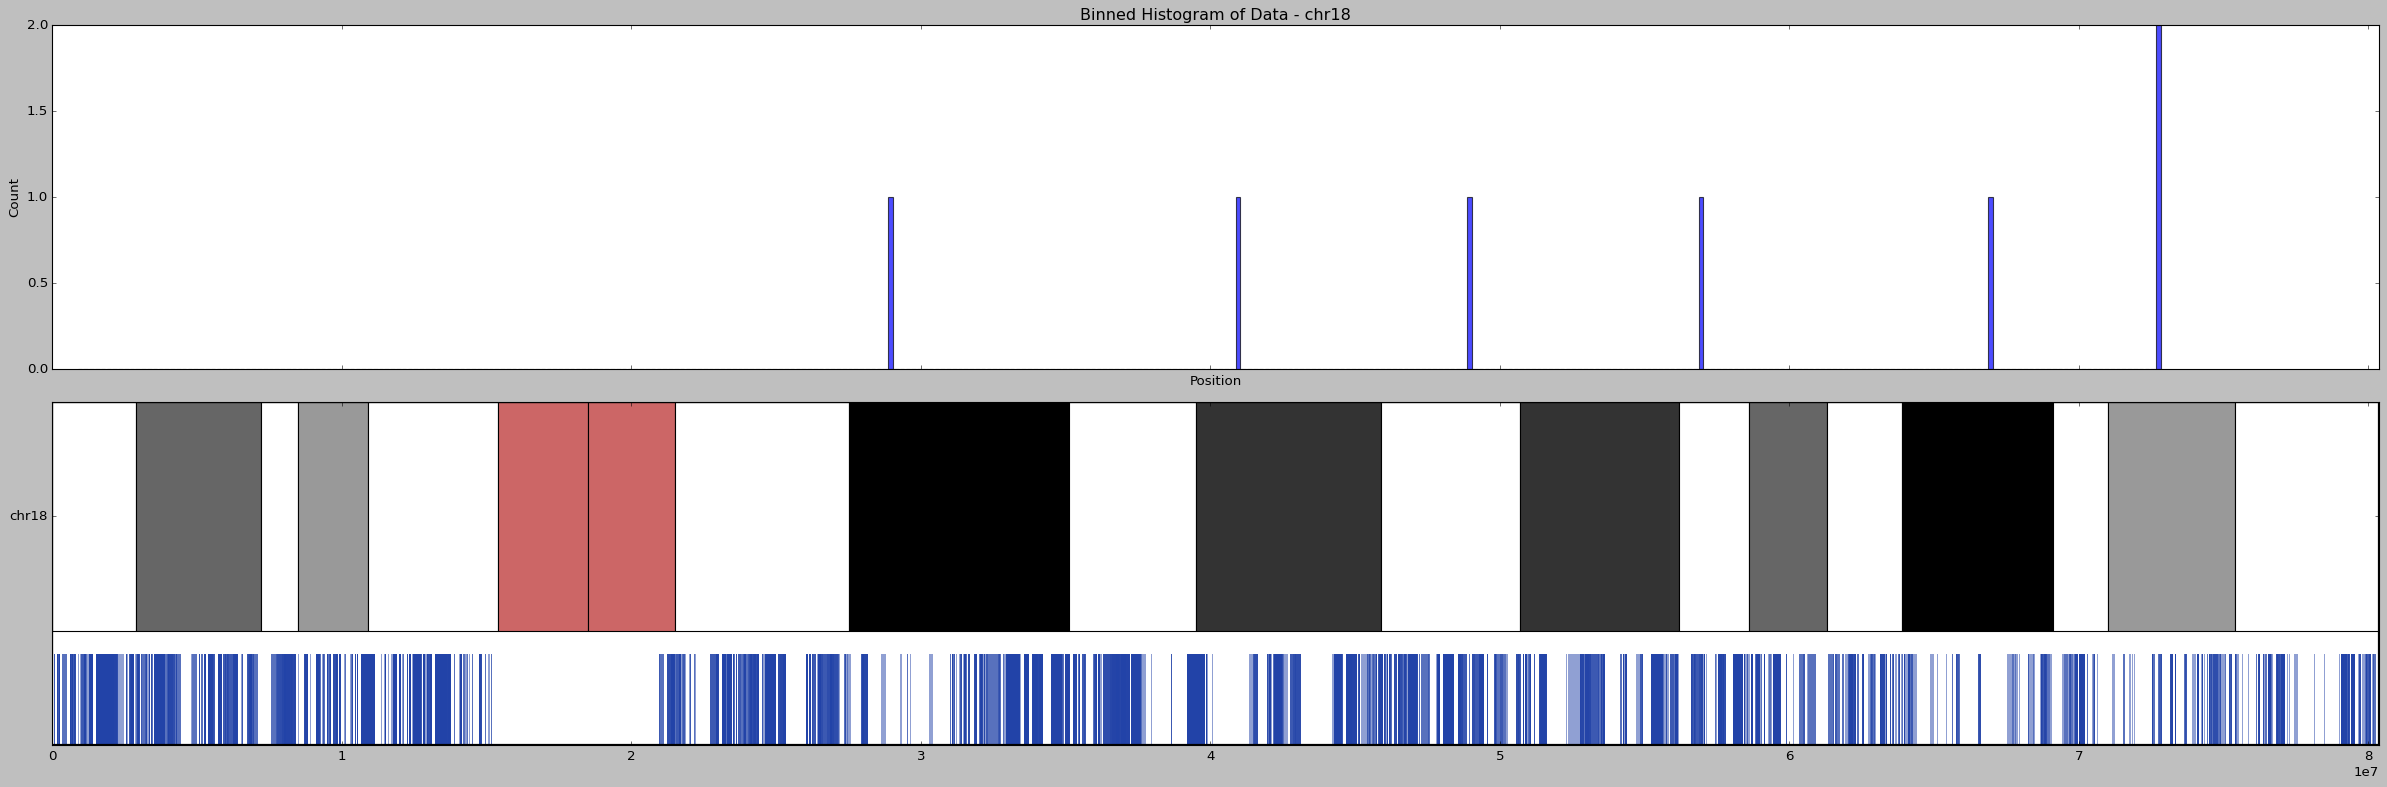

chr19


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


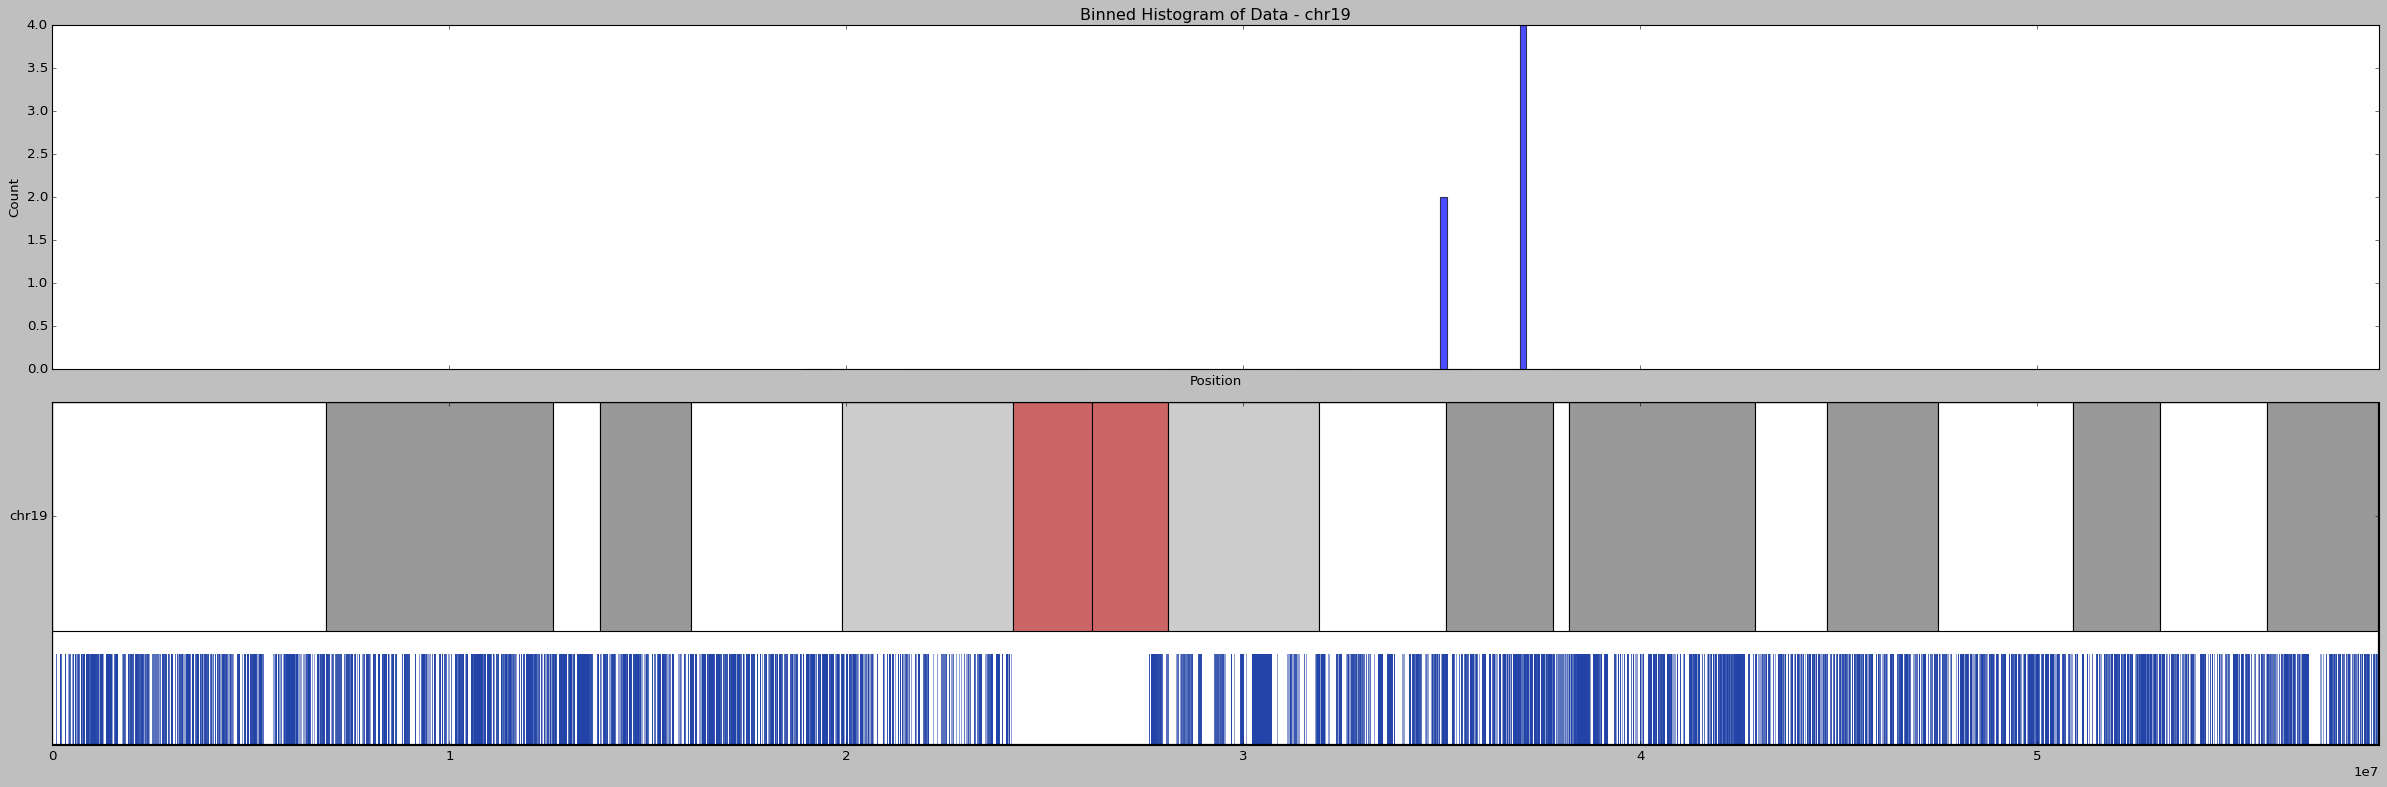

chr20


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


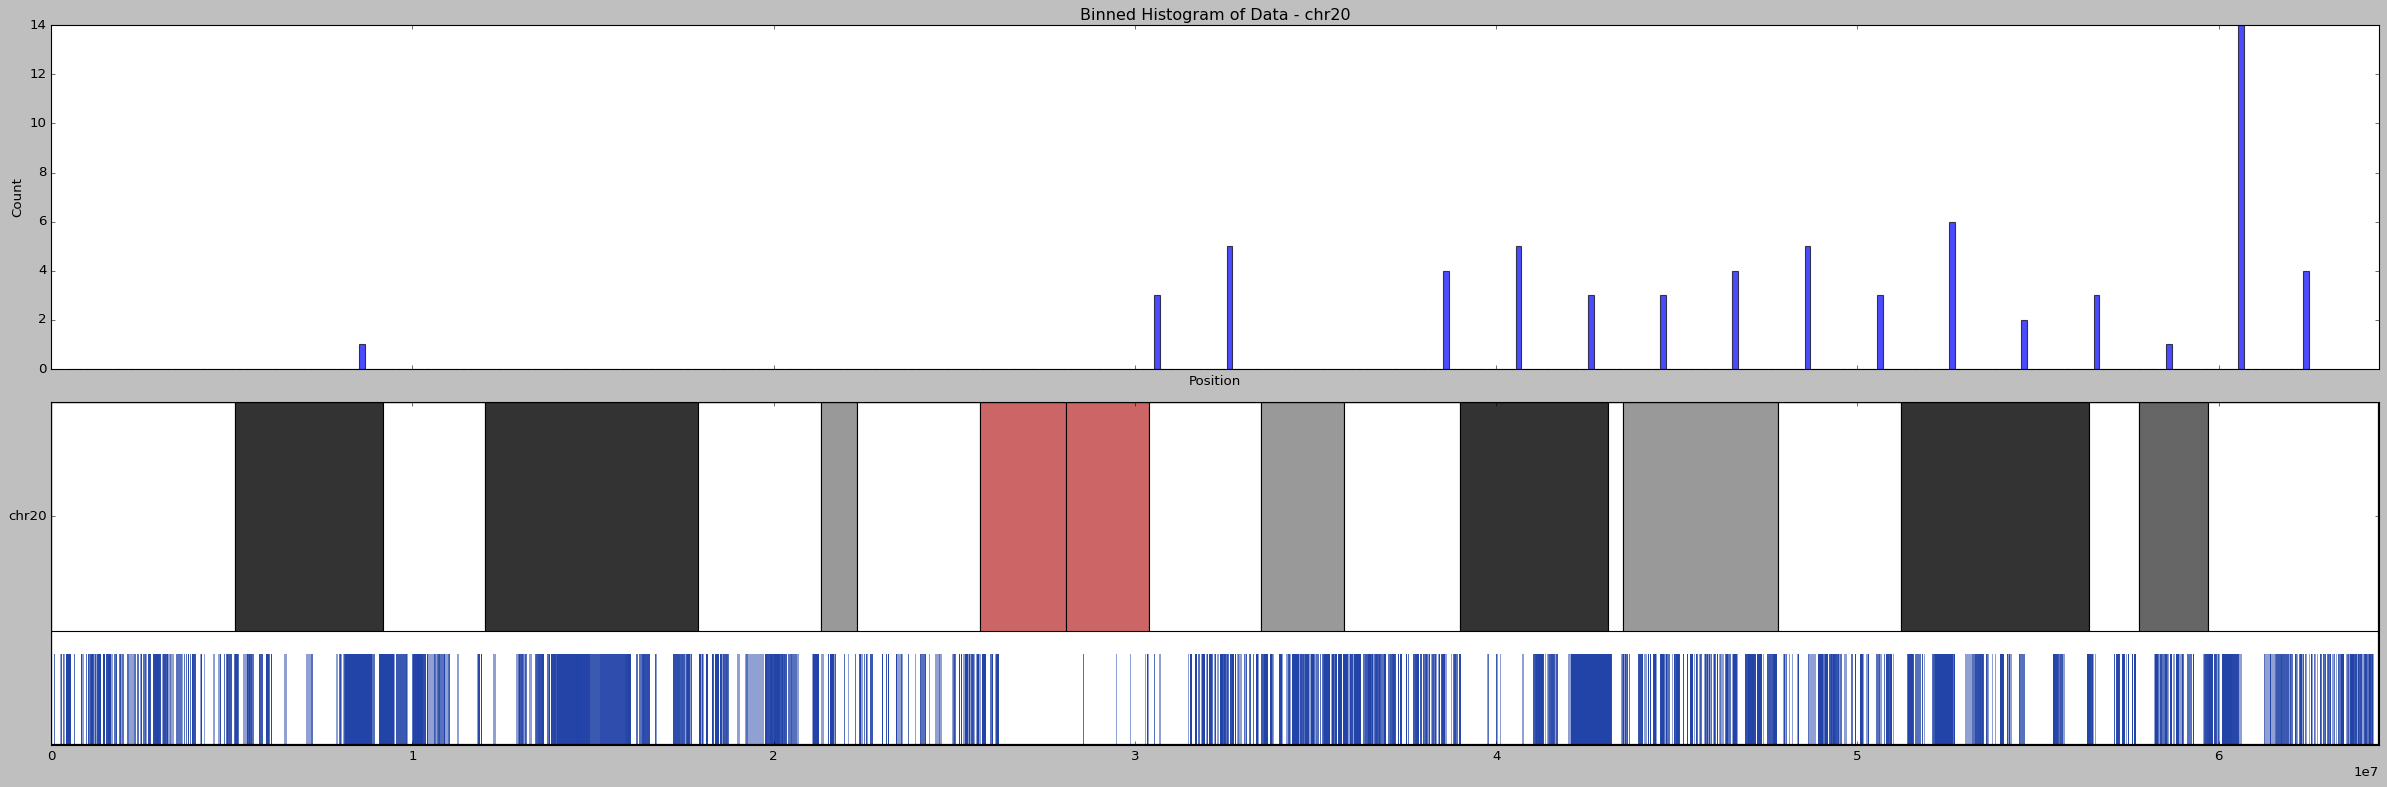

chr21


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


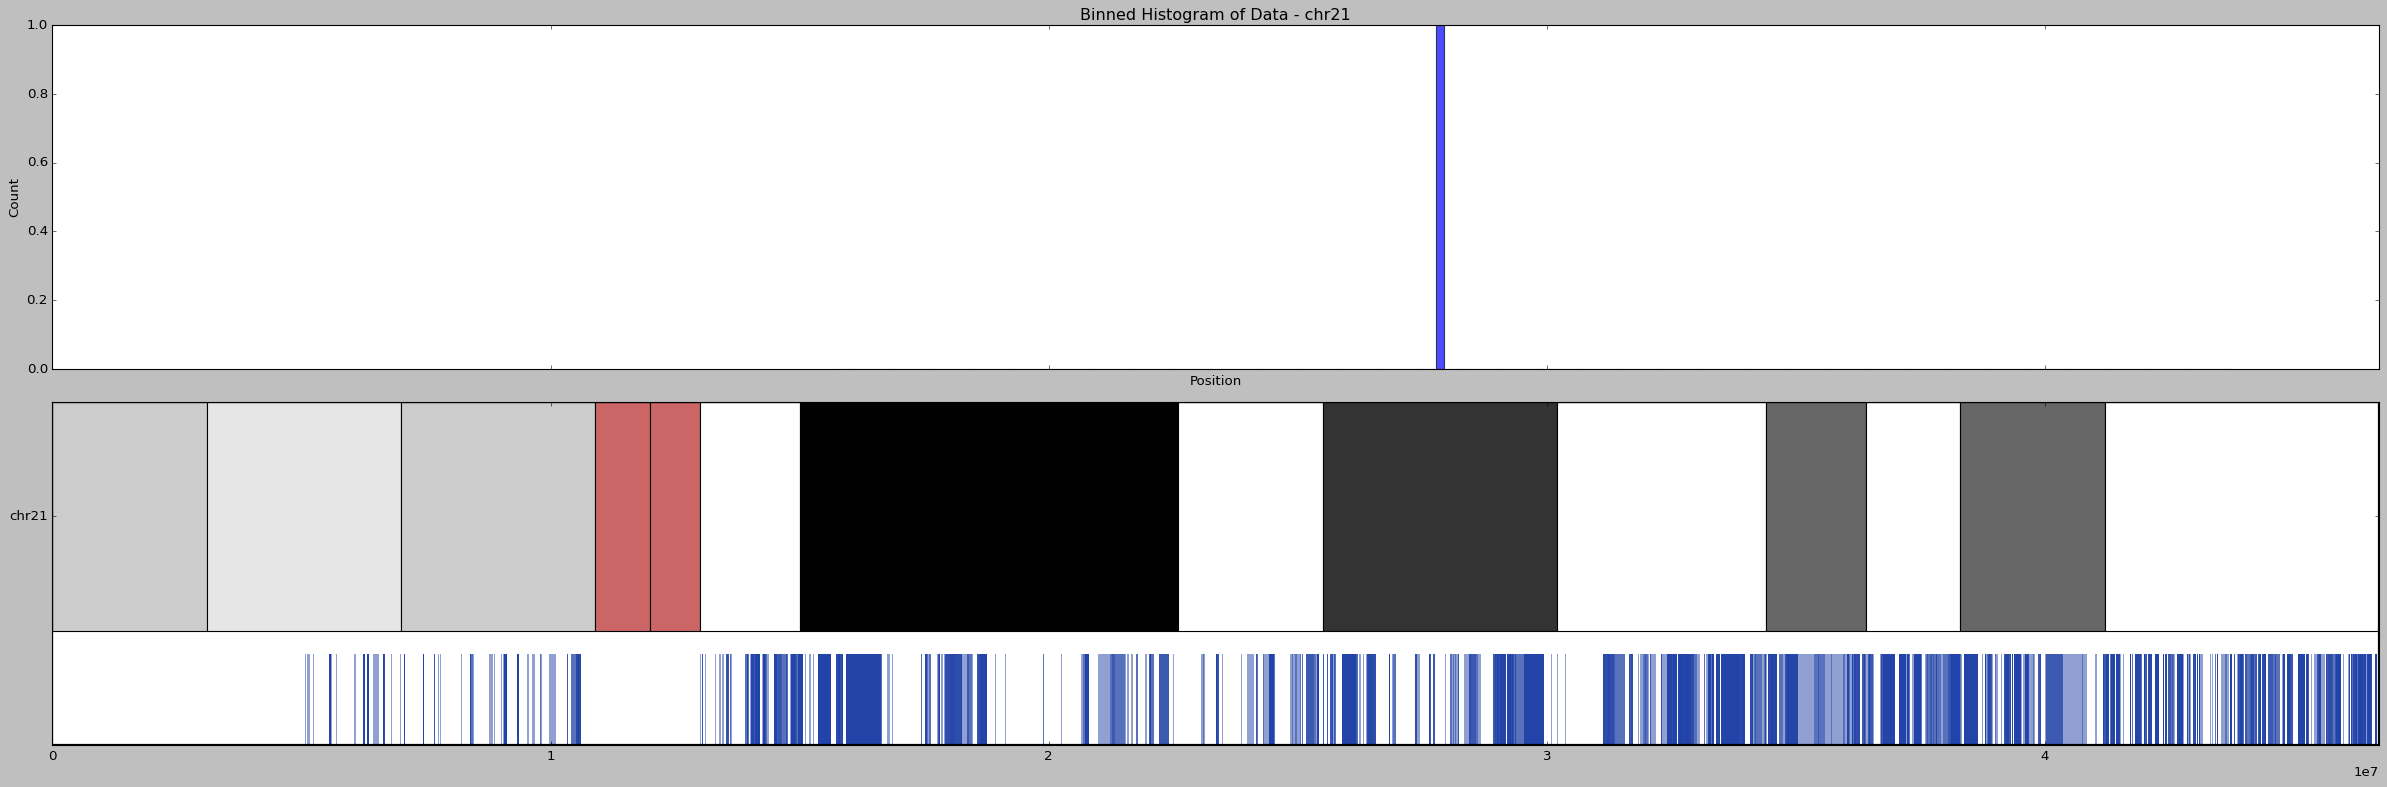

chr22


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


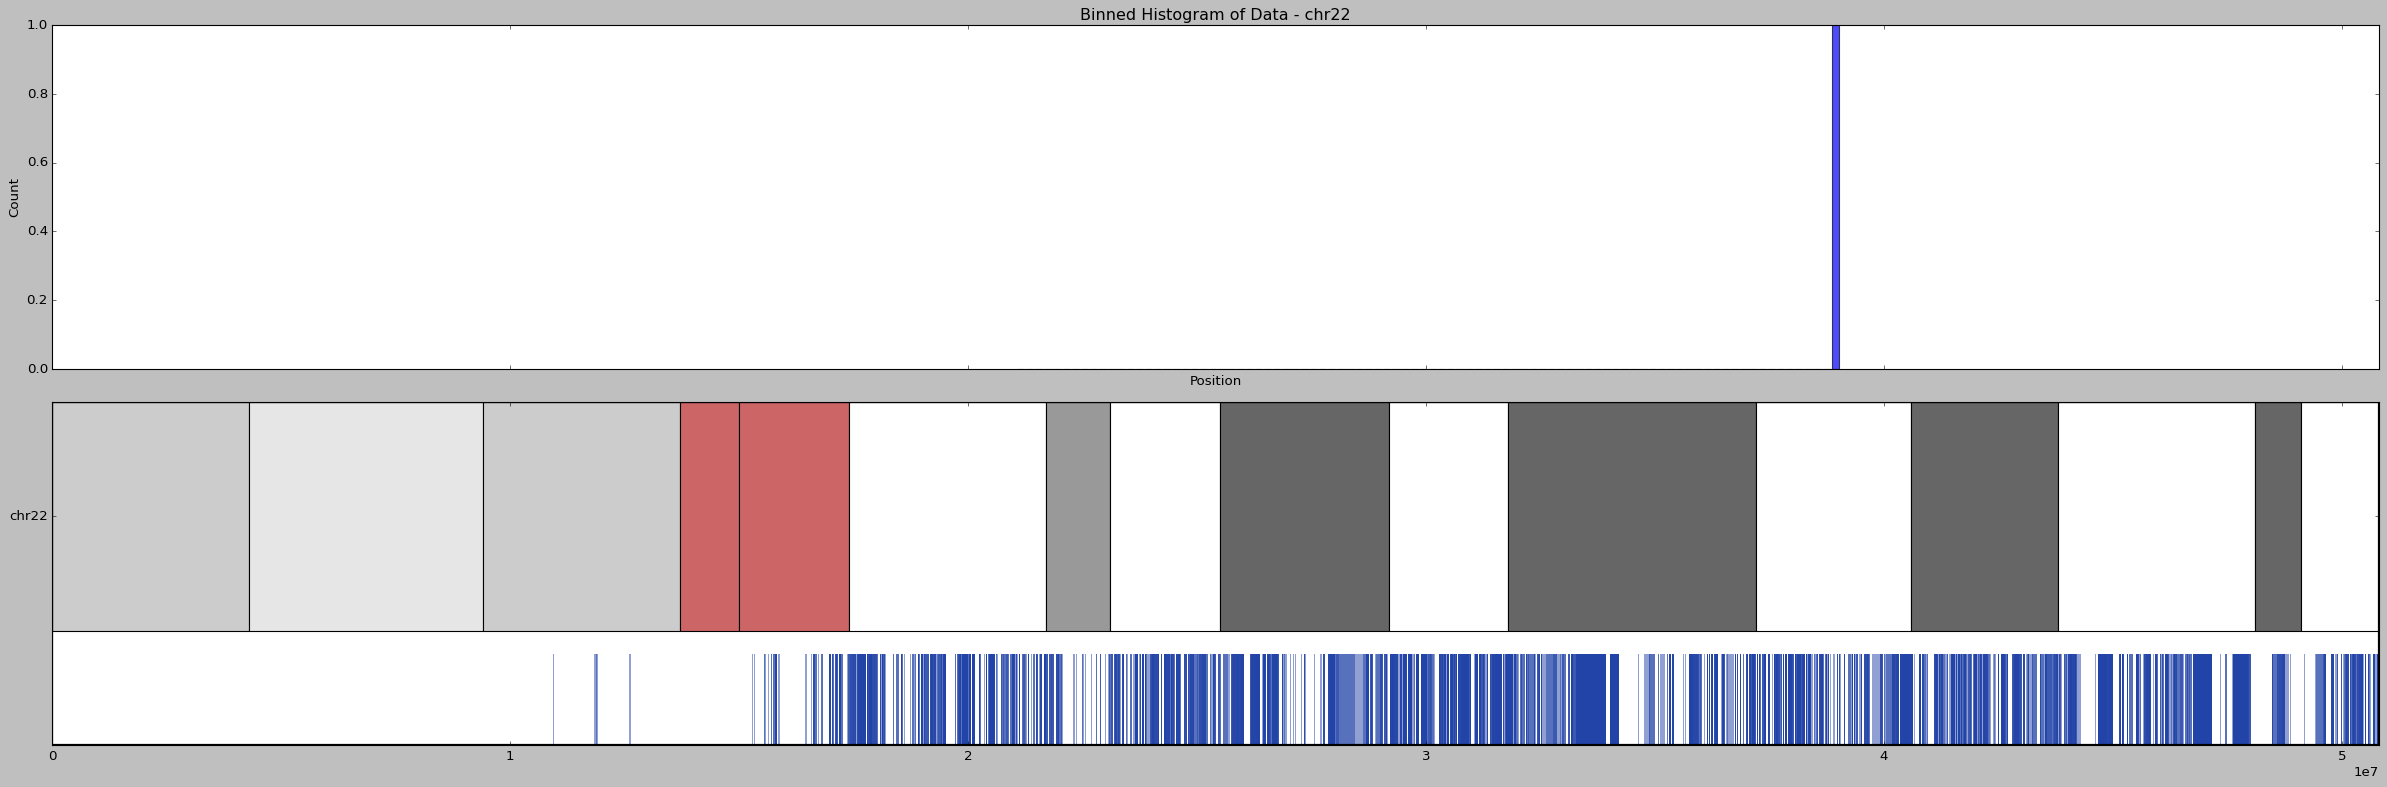

chrX


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


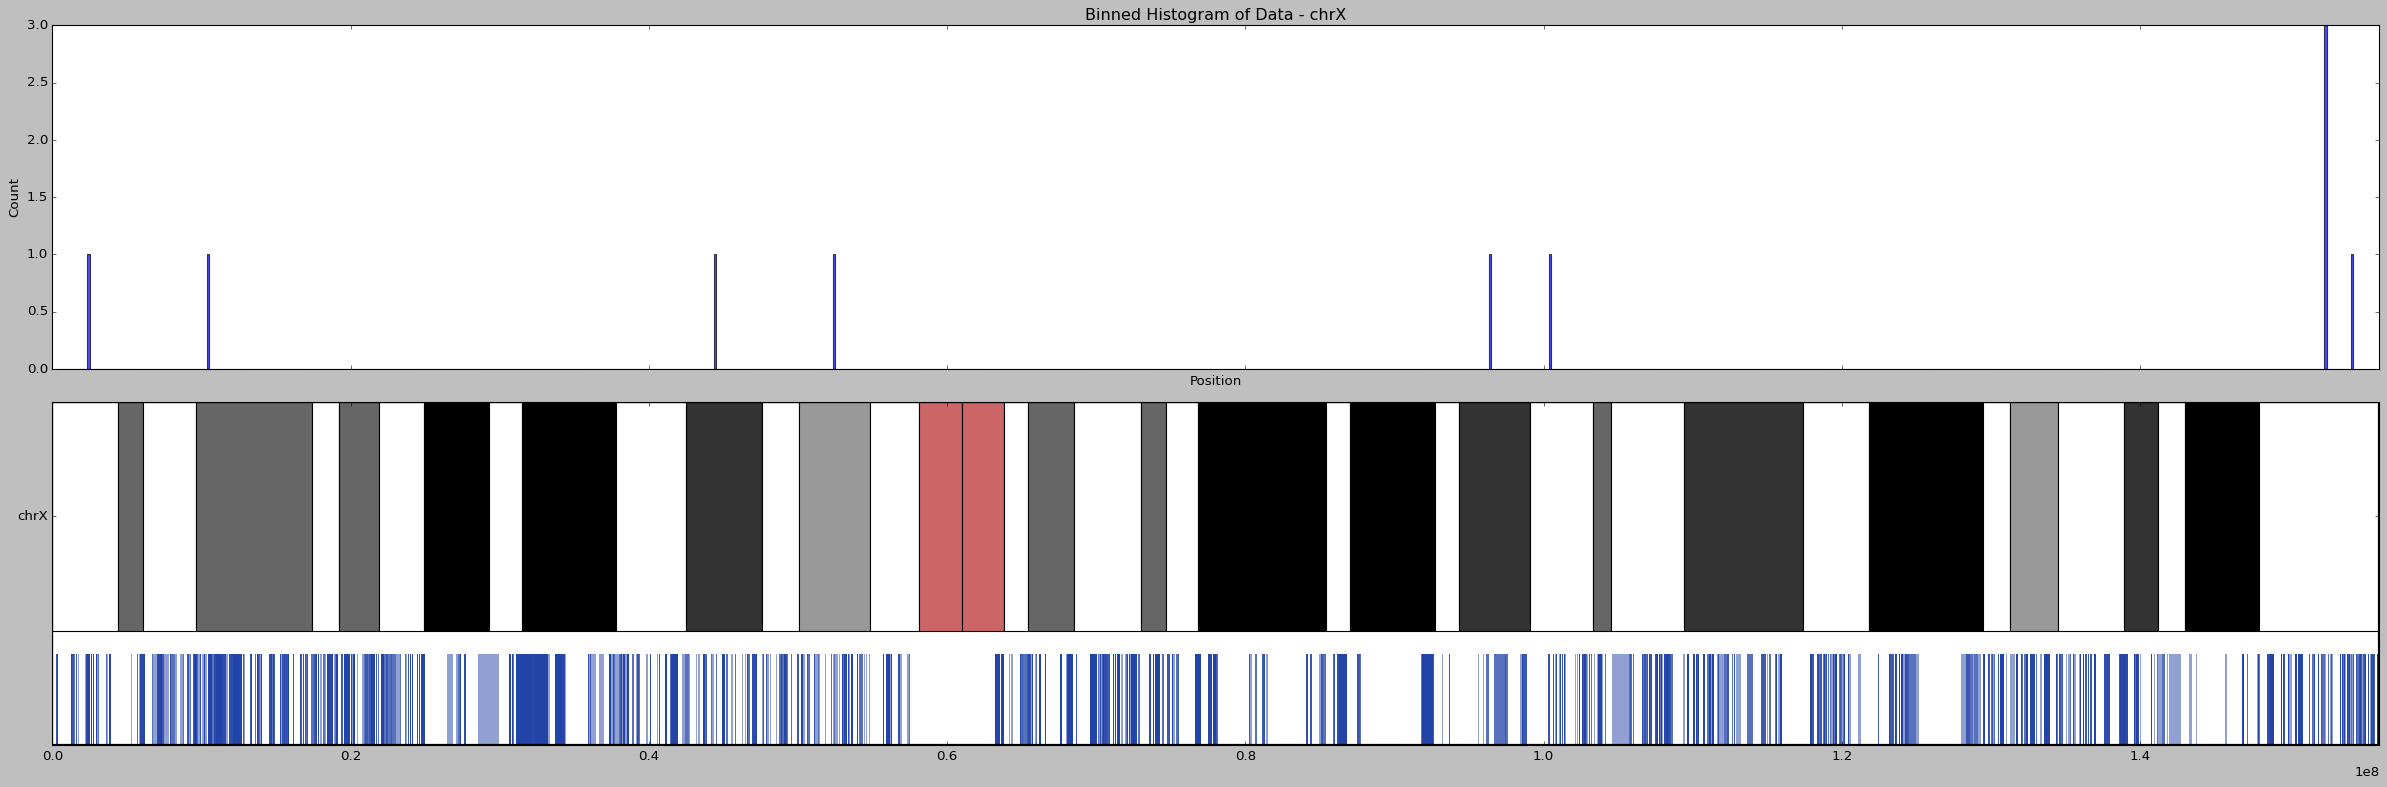

chrY
No data available for chromosome: chrY


/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideo['width'] = ideo.end - ideo.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['width'] = genes.end - genes.start
/var/folders/j6/2g6n5jcx4dz5dncsnj0mt2p40000gn/T/ipykernel_61865/2101622681.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


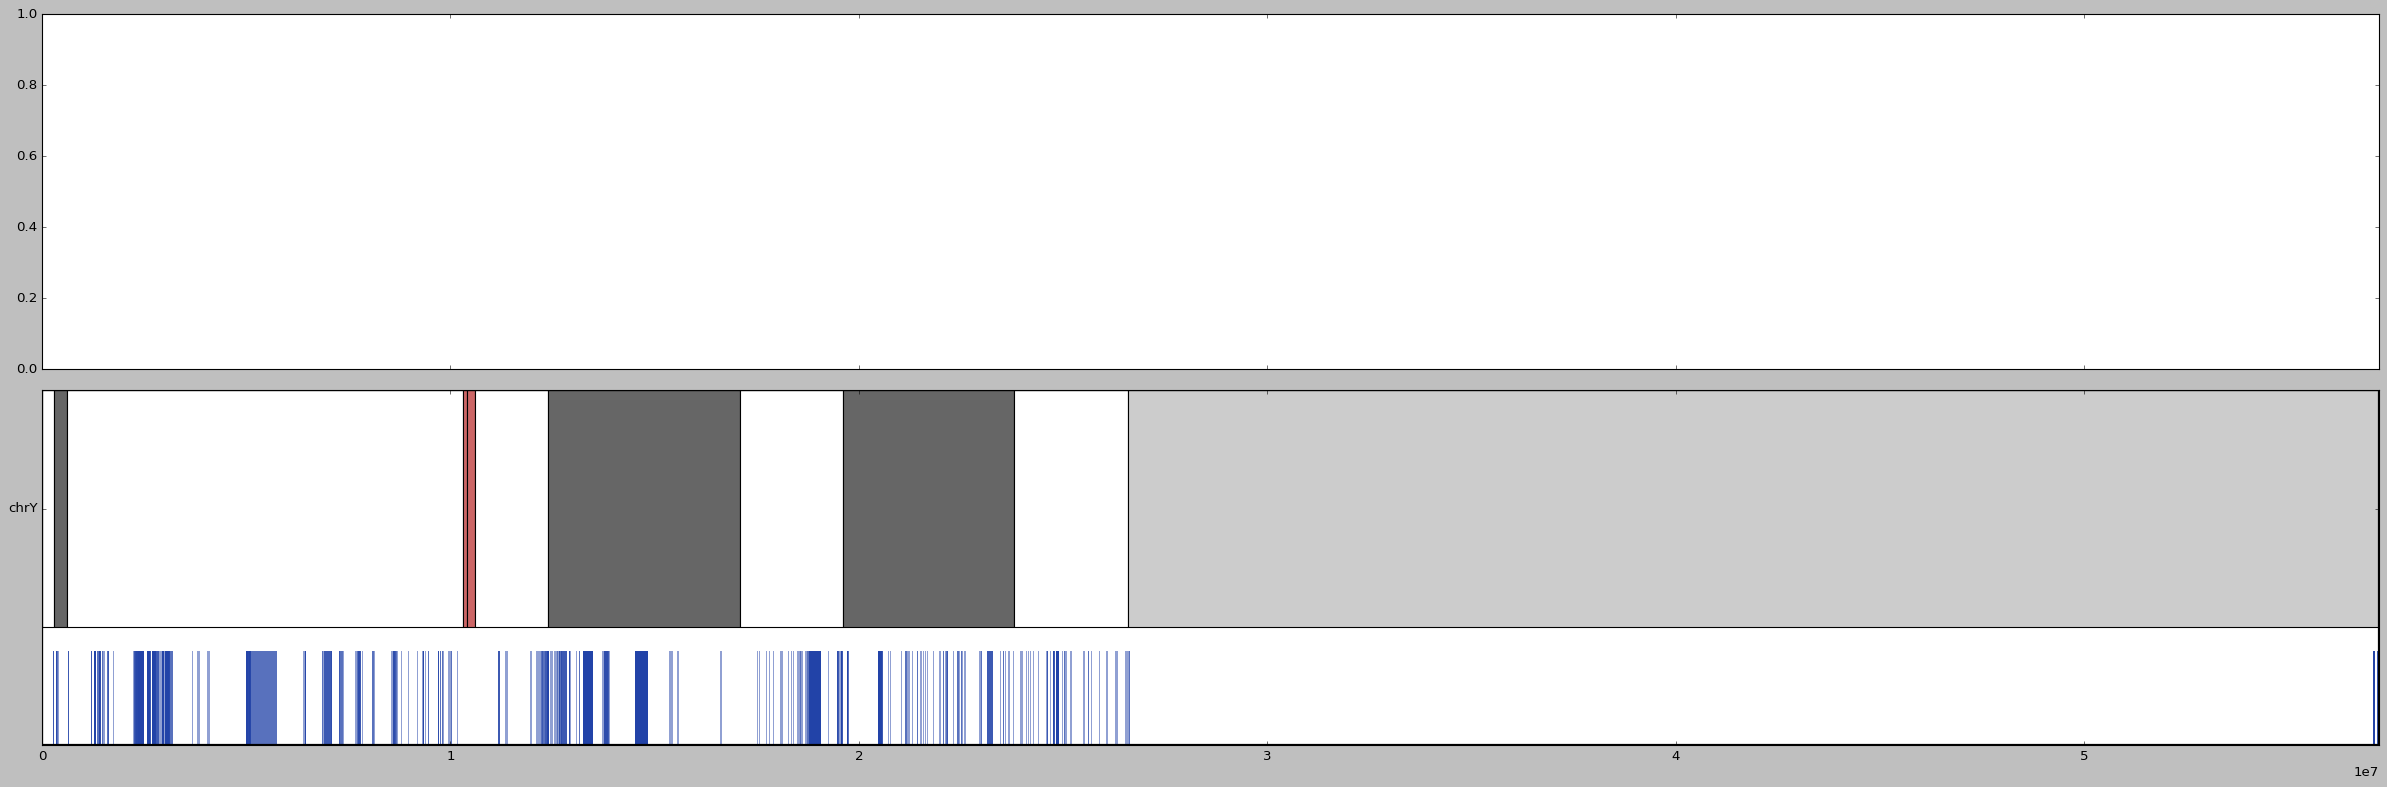

In [59]:
for chr in chromosome_list:
    print(chr)
    plot_combined(chr, binned_data, bin_size, ideo, genes)